In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import os
import warnings
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from enum import Enum
from kneed import KneeLocator
warnings.filterwarnings("ignore")

###### Data Analysis

In [6]:
song_data = pd.read_csv('datasets/Spotify_Dataset_V3.csv', delimiter=';')
song_data.info()
song_data.describe()
spotify_song_data = song_data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651936 entries, 0 to 651935
Data columns (total 20 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Rank                              651936 non-null  int64  
 1   Title                             651936 non-null  object 
 2   Artists                           651936 non-null  object 
 3   Date                              651936 non-null  object 
 4   Danceability                      651936 non-null  float64
 5   Energy                            651936 non-null  float64
 6   Loudness                          651936 non-null  float64
 7   Speechiness                       651936 non-null  float64
 8   Acousticness                      651936 non-null  float64
 9   Instrumentalness                  651936 non-null  float64
 10  Valence                           651936 non-null  float64
 11  # of Artist                       651936 non-null  o

In [7]:
# 转换“Date”列的数据类型为 'datetime'，确保正确解析日期格式
spotify_song_data['Date'] = pd.to_datetime(spotify_song_data['Date'], format='%d/%m/%Y')

# 创建一个新列“Data_Month”，只包含年份和月份
spotify_song_data['Data_Month'] = spotify_song_data['Date'].dt.to_period('M')

# 显示更新后的数据格式
spotify_song_data.head()

# 计算每首歌每月的平均分数
average_monthly_points = spotify_song_data.groupby(['id', 'Data_Month'])['Points (Total)'].mean().reset_index()

# 重命名列以反映这是平均值
average_monthly_points.rename(columns={'Points (Total)': 'Average_Points'}, inplace=True)

# Merge this new data with the original data to maintain all information
monthly_data = pd.merge(spotify_song_data, average_monthly_points, on=['id', 'Data_Month'], how='left')

# Dropping daily points and other unnecessary columns
columns_to_drop = ['Points (Total)', 'Points (Ind for each Artist/Nat)', 'Date', 'Rank']
monthly_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Dropping duplicates as we now have monthly data
monthly_data.drop_duplicates(inplace=True)

monthly_data.head()


# 根据 'Data_Month' 和 'Average_Points' 对数据进行排序
monthly_data.sort_values(by=['Data_Month', 'Average_Points'], ascending=[True, False], inplace=True)

# 由于每首歌可能有多个艺术家，我们需要确保这些信息被保留
# 我们将创建一个函数来聚合艺术家信息，并应用这个函数

def aggregate_artists(series):
    return ", ".join(series.unique())  # 保留唯一的艺术家名字，避免重复

# 对 'Artists' 列应用此函数
monthly_data_grouped = monthly_data.groupby(['Title', 'Data_Month', 'id', 'Song URL', 'Average_Points'], as_index=False)
monthly_data_final = monthly_data_grouped.agg({
    'Artists': aggregate_artists,
    'Danceability': 'first',
    'Energy': 'first',
    'Loudness': 'first',
    'Speechiness': 'first',
    'Acousticness': 'first',
    'Instrumentalness': 'first',
    'Valence': 'first',
    'Continent': 'first',
    'Nationality': 'first'  # 如果有多个国籍，此处可能需要额外的逻辑
})

monthly_data_final.head()  # 展示处理后的数据集的前几行

,Title,Data_Month,id,Song URL,Average_Points,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Continent,Nationality
0,'98 Braves,2023-03,3oZ6dlSfCE9gZ55MGPJctc,https://open.spotify.com/track/3oZ6dlSfCE9gZ55...,71.750000,Morgan Wallen,0.488,0.670,-5759.0,0.027,0.097,0.0,0.484,Anglo-America,United States
1,!,2019-08,5a1ofLoPiAn5xxf5UE6472,https://open.spotify.com/track/5a1ofLoPiAn5xxf...,97.000000,Trippie Redd,0.725,0.543,-6311.0,0.084,0.030,0.0,0.693,Anglo-America,United States
2,#PROUDCATOWNERREMIX,2019-08,5dkZ2DrcPJrqwlRQe6Q35e,https://open.spotify.com/track/5dkZ2DrcPJrqwlR...,12.000000,"XXXTENTACION, Rico Nasty",0.783,0.522,-6229.0,0.390,0.029,0.0,0.235,Anglo-America,United States
3,$$$,2018-03,65u1dHQyQyE4y4aN2eDmMF,https://open.spotify.com/track/65u1dHQyQyE4y4a...,85.888889,XXXTENTACION,0.774,0.507,-6952.0,0.065,0.064,0.0,0.508,Anglo-America,United States
4,$$$,2018-06,65u1dHQyQyE4y4aN2eDmMF,https://open.spotify.com/track/65u1dHQyQyE4y4a...,81.666667,XXXTENTACION,0.774,0.507,-6952.0,0.065,0.064,0.0,0.508,Anglo-America,United States


#### What drives cross-regional popularity of music; is it the artist, or something about the song?
1. Identify the correlation between musical attribution and point
2. FInd out the correlation between artists, nationality and point

Firstly, identify the correlation between musical attribution and point

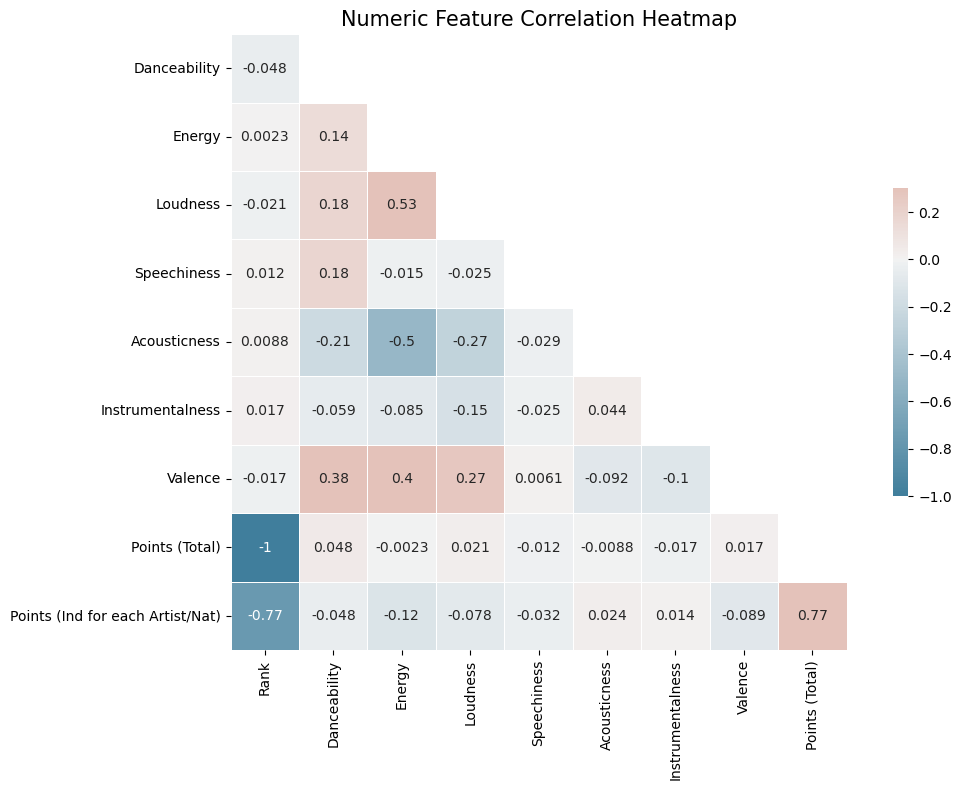

In [8]:
# Compute the correlation matrix
corr_matrix = spotify_song_data.corr()

# remove the first row and last column
corr_matrix = corr_matrix.iloc[1:, :-1]

# Generate a mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k = 1)

# Set matplotlib figure
plt.figure(figsize=(12, 8))

# Generate colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Title and display the plot
plt.title("Numeric Feature Correlation Heatmap", fontsize=15)
plt.show()

We can clearly see that there are not any correlation between musical attribution and Point almost
But we can still concentrate on whether exists the correlation between musical attribution and different nationalities

Due to the data of nationalities are too many, so we transfer them to continent, identify the correlaiton of continent and attribution

In [9]:
# Calculating means of the musical features in each continent
musical_features = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 
                    'Acousticness', 'Instrumentalness', 'Valence']
mean_values_per_continent = spotify_song_data.groupby('Continent')[musical_features].mean()

# Displaying the means
mean_values_per_continent.sort_values(by='Danceability', ascending=False)

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence
Continent,,,,,,,
Latin-America,0.748943,0.709506,-4337.162528,0.124748,0.238553,0.003229,0.632776
Africa,0.735743,0.677075,-4897.479589,0.092409,0.196211,0.016327,0.541201
Asia,0.707159,0.697001,-4945.405014,0.090986,0.161881,0.001735,0.541093
Anglo-America,0.687851,0.614019,-5796.660216,0.116090,0.228825,0.010283,0.472789
Europe,0.669450,0.666961,-5264.483280,0.085314,0.234237,0.007389,0.518538
Oceania,0.630588,0.668204,-5358.014521,0.090270,0.232568,0.001744,0.476431
Unknown,0.626140,0.740004,-4521.699591,0.053744,0.076103,0.030632,0.468153


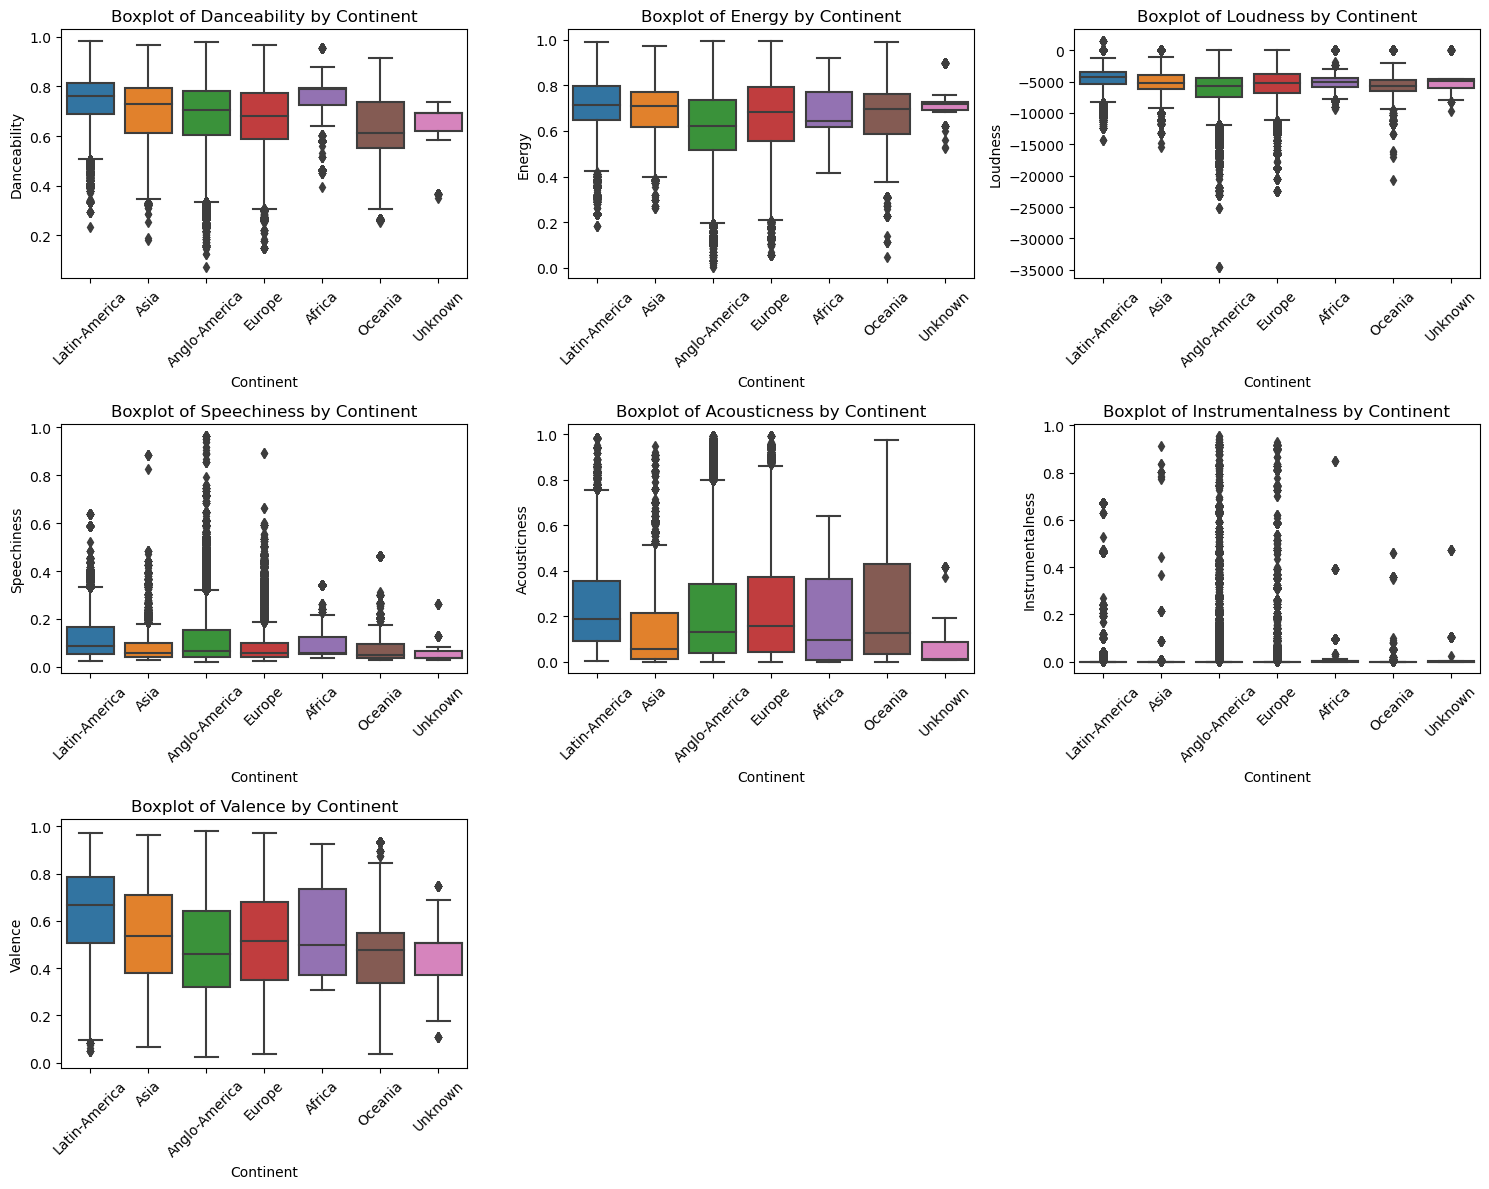

In [10]:
# Set matplotlib figure
plt.figure(figsize=(15, 12))

# Create subplots for each musical feature
for i, feature in enumerate(musical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Continent', y=feature, data=spotify_song_data)
    plt.title(f'Boxplot of {feature} by Continent')
    plt.xticks(rotation=45)
    plt.tight_layout()

# Display the plots
plt.show()

Danceability：Latin-America的歌曲在可舞动性上的中位数最高

Energy：不同大陆在能量特质上的分布差异较大，其中“Unknown”大陆的中位数最高

Loudness：大多数大陆在响度上的分布相近，但“Anglo-America”稍微较低

Speechiness：Latin-America的歌曲在说唱性上的分布最高

Acousticness：Latin-America的歌曲在声学性上的中位数也较高

Instrumentalness：“Unknown”大陆在乐器性上的中位数最高

Valence：Latin-America在正向情感度上的分布也较高

Next, we find out if there are corellation between artist and point

Since the 'Artists' field seems to contain multiple artists in some records, we will use 'Artist (Ind.)' for analysis.

In [11]:
# Calculating the average points for each artist
average_points_per_artist = spotify_song_data.groupby('Artist (Ind.)')['Points (Total)'].mean()

# Converting the series to a dataframe and resetting the index
average_points_df = average_points_per_artist.reset_index()

# Renaming the columns for clarity
average_points_df.rename(columns={'Points (Total)': 'Average Points'}, inplace=True)

# Displaying the first few rows of the dataframe
average_points_df.head()

,Artist (Ind.),Average Points
0,$NOT,51.978495
1,$uicideboy$,68.100000
2,(G)I-DLE,69.765217
3,*NSYNC,75.931034
4,070 Shake,144.101266


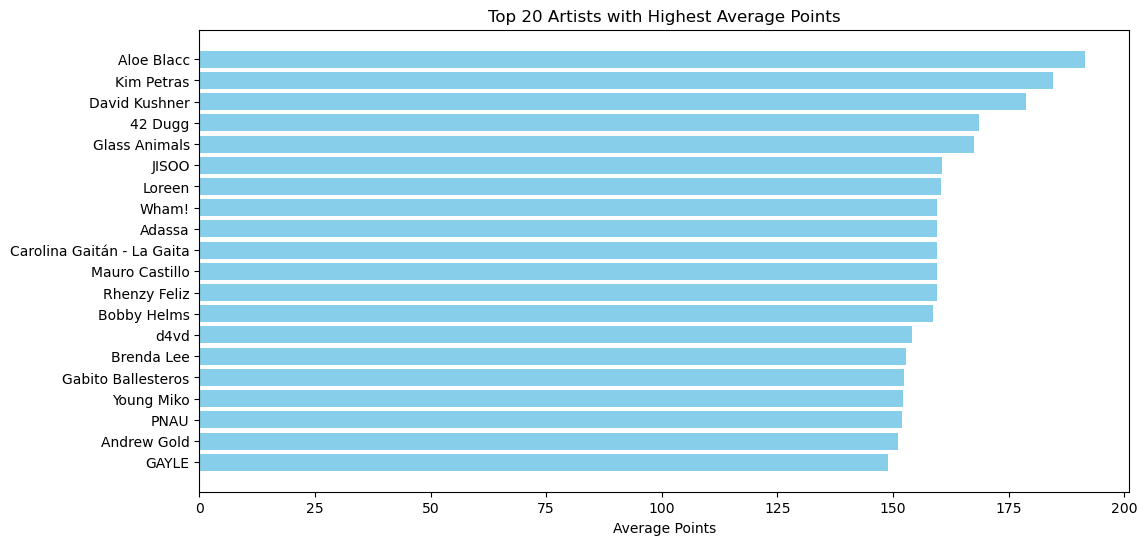

In [12]:
# Selecting the top artists based on average points for visualization
top_artists = average_points_df.nlargest(20, 'Average Points')

# Creating a bar plot
plt.figure(figsize=(12, 6))
plt.barh(top_artists['Artist (Ind.)'], top_artists['Average Points'], color='skyblue')
plt.xlabel('Average Points')
plt.title('Top 20 Artists with Highest Average Points')
plt.gca().invert_yaxis()  # To have the highest on top
plt.show()

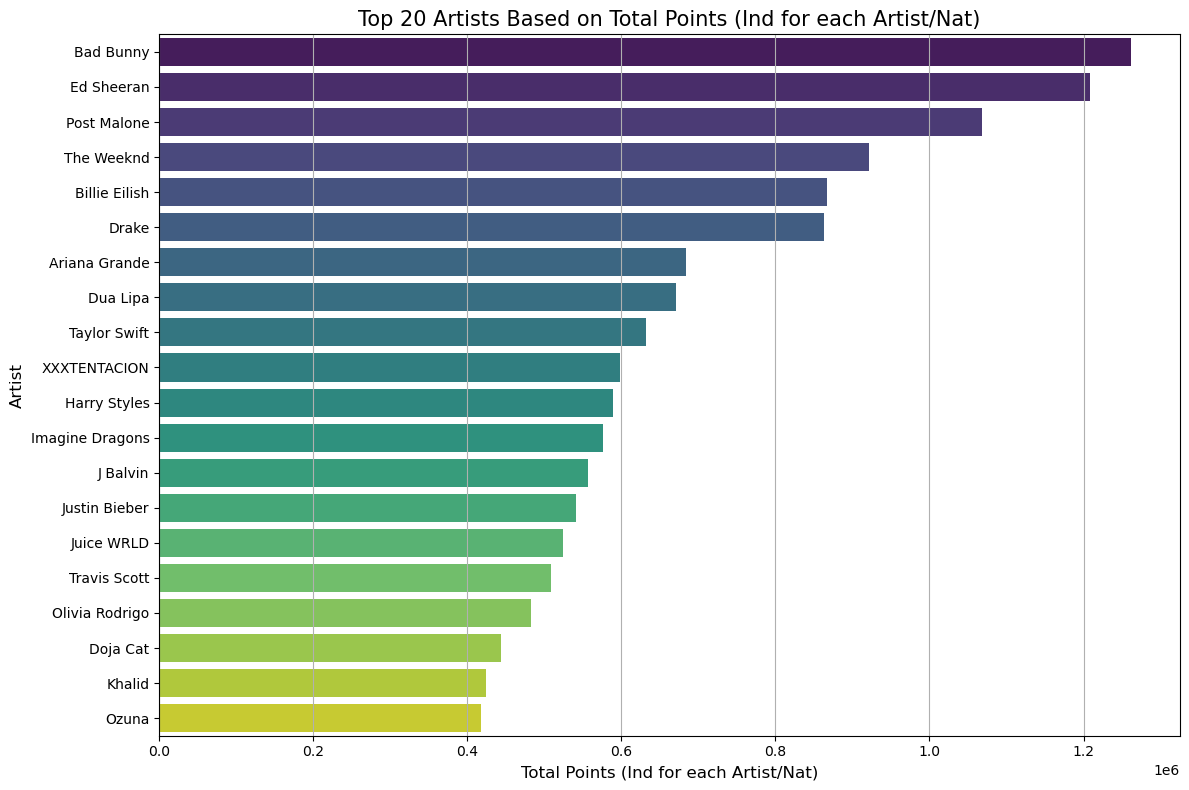

In [13]:
# Grouping by artist and calculating the total points for each artist
artist_total_points = spotify_song_data.groupby('Artist (Ind.)')['Points (Ind for each Artist/Nat)'].sum()

# Sorting the artists by total points and selecting the top 20
top_artists = artist_total_points.sort_values(ascending=False).head(20)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.xlabel('Total Points (Ind for each Artist/Nat)', fontsize=12)
plt.ylabel('Artist', fontsize=12)
plt.title('Top 20 Artists Based on Total Points (Ind for each Artist/Nat)', fontsize=15)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

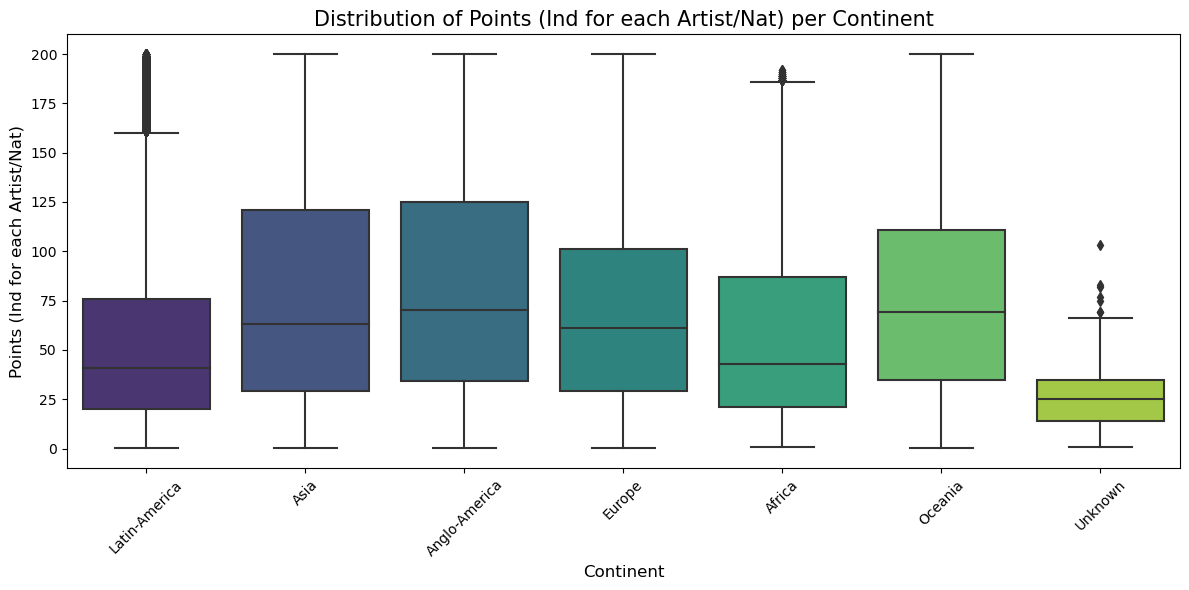

Continent
Anglo-America    81.289828
Oceania          79.639849
Asia             77.480303
Europe           72.581015
Africa           56.795958
Latin-America    53.445319
Unknown          25.442294
Name: Points (Ind for each Artist/Nat), dtype: float64

In [14]:


# Calculating average Points per continent
avg_points_per_continent = spotify_song_data.groupby('Continent')['Points (Ind for each Artist/Nat)'].mean().sort_values(ascending=False)

# Plotting boxplot for Points distribution per continent
plt.figure(figsize=(12, 6))
sns.boxplot(data=spotify_song_data, x='Continent', y='Points (Ind for each Artist/Nat)', palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Continent', fontsize=12)
plt.ylabel('Points (Ind for each Artist/Nat)', fontsize=12)
plt.title('Distribution of Points (Ind for each Artist/Nat) per Continent', fontsize=15)
plt.tight_layout()
plt.show()

# Displaying average Points per continent
avg_points_per_continent

we can see a huge difference, so it shows artist is an important factor for cross-reginal popularity

In [15]:
# ANOVA Test
f_stat, p_value = stats.f_oneway(*(spotify_song_data['Points (Ind for each Artist/Nat)'][spotify_song_data['Continent'] == continent] for continent in spotify_song_data['Continent'].unique()))

(f_stat, p_value)

# Since the p-value is much smaller than the common significance level

# This shows that the continent may indeed be related to the Points of the song

(4974.431855248046, 0.0)

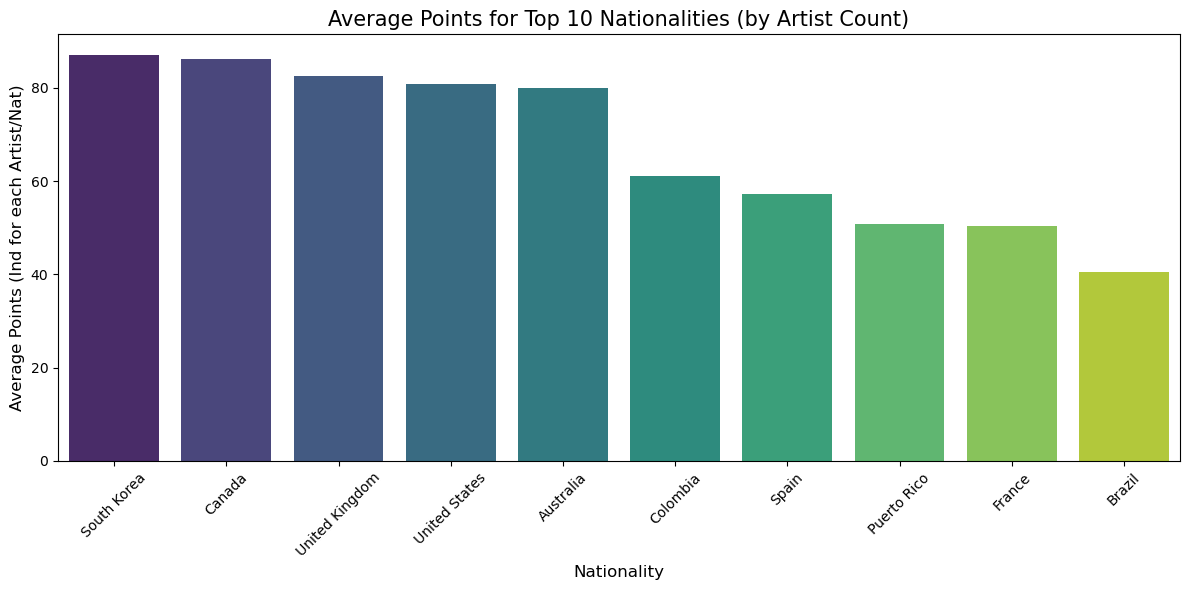

Nationality
South Korea       87.144093
Canada            86.176786
United Kingdom    82.531391
United States     80.877584
Australia         79.998835
Colombia          61.169901
Spain             57.155587
Puerto Rico       50.886091
France            50.361817
Brazil            40.573903
Name: Points (Ind for each Artist/Nat), dtype: float64

In [16]:
# Besides, nationality would like to be a factor
artist_count_per_nationality = spotify_song_data['Nationality'].value_counts()

# Selecting the top 10 nationalities that have the most artists
top_nationalities_by_count = artist_count_per_nationality.head(10).index

# Calculating the average points for these top nationalities
avg_points_top_nationalities = spotify_song_data[spotify_song_data['Nationality'].isin(top_nationalities_by_count)].groupby('Nationality')['Points (Ind for each Artist/Nat)'].mean().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_points_top_nationalities.index, y=avg_points_top_nationalities.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Nationality', fontsize=12)
plt.ylabel('Average Points (Ind for each Artist/Nat)', fontsize=12)
plt.title('Average Points for Top 10 Nationalities (by Artist Count)', fontsize=15)
plt.tight_layout()
plt.show()

# Displaying the data
avg_points_top_nationalities

Can we figure out which artists or genres are going to be popular in 2024 given the historic data from 2017?

###### Data preprogressing

In [17]:
#Create a new column for each artists' average score

# Step 1: Calculate the average points for each artist
artist_avg_points = spotify_song_data.groupby('Artist (Ind.)')['Points (Total)'].mean()

# Step 2: Function that returns the average points of artists
def get_artist_average_points(artists):
    # For multiple artists, we calculate the mean of their average points
    artist_list = artists.split(", ")  # Assuming artists are separated by ", "
    avg_points_list = [artist_avg_points.get(artist, 0) for artist in artist_list]
    return sum(avg_points_list) / len(avg_points_list) if avg_points_list else 0

# Step 3: Apply the function to the 'Artists' column
spotify_song_data['Artist_Average_Points'] = spotify_song_data['Artists'].apply(get_artist_average_points)

# Show the first few rows of the dataframe to verify the new column
spotify_song_data[['Artists', 'Artist_Average_Points']].head()


,Artists,Artist_Average_Points
0,"Eslabon Armado, Peso Pluma",130.833693
1,"Eslabon Armado, Peso Pluma",130.833693
2,Bad Bunny,121.477141
3,"Yng Lvcas, Peso Pluma",132.081395
4,"Yng Lvcas, Peso Pluma",132.081395


In [18]:
spotify_one_hot = pd.get_dummies(spotify_song_data, columns=['Continent'])

# Applying one-hot encoding to the 'Continent' column and adding it to the original dataframe
spotify_song_data = pd.concat([spotify_song_data, pd.get_dummies(spotify_song_data['Continent'], prefix='Continent')], axis=1)

spotify_song_data.head(4)

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Song URL,Data_Month,Artist_Average_Points,Continent_Africa,Continent_Anglo-America,Continent_Asia,Continent_Europe,Continent_Latin-America,Continent_Oceania,Continent_Unknown
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,https://open.spotify.com/track/3qQbCzHBycnDpGs...,2023-05,130.833693,0,0,0,0,1,0,0
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,https://open.spotify.com/track/3qQbCzHBycnDpGs...,2023-05,130.833693,0,0,0,0,1,0,0
2,2,WHERE SHE GOES,Bad Bunny,2023-05-29,0.652,0.800,-4019.0,0.061,0.143,0.629,...,https://open.spotify.com/track/7ro0hRteUMfnOio...,2023-05,121.477141,0,0,0,0,1,0,0
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,2023-05,132.081395,0,0,0,0,1,0,0


In [19]:
# Step 1: Grouping the data by artist and calculating the total points
artist_total_points = spotify_song_data.groupby('Artist (Ind.)')['Points (Ind for each Artist/Nat)'].sum()

# Step 2: Creating a new column in the original dataframe that maps the total points for each artist
spotify_song_data['Artist_Total_Points'] = spotify_song_data['Artist (Ind.)'].map(artist_total_points)

spotify_song_data[['Artist (Ind.)', 'Artist_Total_Points']].head()

,Artist (Ind.),Artist_Total_Points
0,Eslabon Armado,1.081600e+04
1,Peso Pluma,6.299500e+04
2,Bad Bunny,1.262144e+06
3,Yng Lvcas,1.204600e+04
4,Peso Pluma,6.299500e+04


In [20]:
# Extracting year and month
spotify_song_data['Year'] = pd.to_datetime(spotify_song_data['Date']).dt.year
spotify_song_data['Month'] = pd.to_datetime(spotify_song_data['Date']).dt.month

spotify_song_data[['Date', 'Year', 'Month']].head()

,Date,Year,Month
0,2023-05-29,2023,5
1,2023-05-29,2023,5
2,2023-05-29,2023,5
3,2023-05-29,2023,5
4,2023-05-29,2023,5


###### Model: logistic regression, random forest, naive bayes(baseline)

我们目前处理了三个因素，Artist_Average_Points, Artist_Total_Points, different continent. 
现在我对2017年1月-2017年12月的数据作为训练集进行学习，并根据2023年1月到2023年5月的数据作为对照集测试，
model用logistic regression, random forest, naive bayes，把Point前25%的歌曲表示为流行，预测歌曲是否流行

In [21]:
# Organized Code for the Entire Process

# 1. Data Preprocessing

# Extracting year and month from the 'Date' column
spotify_song_data['Year'] = pd.to_datetime(spotify_song_data['Date']).dt.year
spotify_song_data['Month'] = pd.to_datetime(spotify_song_data['Date']).dt.month

# Defining the target variable based on the top 25% of points
threshold = spotify_song_data['Points (Total)'].quantile(0.75)
spotify_song_data['Popular'] = (spotify_song_data['Points (Total)'] >= threshold).astype(int)

# 2. Feature Selection and Dataset Splitting

# Selecting features and target
continent_features = [col for col in spotify_song_data.columns if col.startswith('Continent_')]
features = ['Artist_Average_Points', 'Artist_Total_Points'] + continent_features
target = 'Popular'

# Splitting the dataset into training and testing sets
train_data = spotify_song_data[(spotify_song_data['Year'] >= 2017)]
#                                & (spotify_song_data['Year'] <= 2022)]
test_data = spotify_song_data[(spotify_song_data['Year'] == 2023)]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Normalizing the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Model Training

# declare model:
# Training the logistic regression model
lr_model = LogisticRegression(random_state=0, class_weight='balanced', verbose=1)
lr_model.fit(X_train_scaled, y_train)

# random forest model training
rf_model = RandomForestClassifier(random_state=0, class_weight='balanced', verbose=1)
rf_model.fit(X_train_scaled, y_train)

# Naive Bayes model training
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# 4. Model Evaluation
print(f"{' Model Evaluation Results ':-^60}\n")
for model in [lr_model, rf_model, nb_model]:
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    print(f'Model: {model.__class__.__name__}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Classification Report:\n {classification_rep}\n')
print("-"*60)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.51888D+05    |proj g|=  1.04624D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      8     10      1     0     0   9.050D-01   4.092D+05
  F =   409238.27034621069     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


----------------- Model Evaluation Results -----------------

Model: LogisticRegression
Accuracy: 0.61
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.51      0.66     31266
           1       0.39      0.86      0.54     11523

    accuracy                           0.61     42789
   macro avg       0.65      0.69      0.60     42789
weighted avg       0.77      0.61      0.62     42789


Model: RandomForestClassifier
Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.61      0.74     31266
           1       0.46      0.87      0.60     11523

    accuracy                           0.68     42789
   macro avg       0.69      0.74      0.67     42789
weighted avg       0.80      0.68      0.70     42789


Model: GaussianNB
Accuracy: 0.63
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76   

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [22]:
def print_evaluation_report(accuracy, classification_rep):
    """
    Print the evaluation report in a formatted manner.

    Parameters:
    accuracy (float): The accuracy score of the model.
    classification_rep (str): The classification report as a string.
    """
    print(f"{' Model Evaluation Results ':-^60}\n")
    print(f"Overall Accuracy: {accuracy:.2%}\n")
    print("Detailed Classification Report:")
    print(classification_rep)
    print("-"*60)

# 4. Model Evaluation

# Evaluating the model on the test set
y_pred = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Printing the evaluation report using the new function
print_evaluation_report(accuracy, classification_rep)

----------------- Model Evaluation Results -----------------

Overall Accuracy: 60.60%

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.51      0.66     31266
           1       0.39      0.86      0.54     11523

    accuracy                           0.61     42789
   macro avg       0.65      0.69      0.60     42789
weighted avg       0.77      0.61      0.62     42789

------------------------------------------------------------


## Analyse regional result/song data
### Preprocessing

Regional data

In [23]:
song_data_region = song_data.copy()
# print the rows where the Date ends with '06/2023'

# remove the song with same id, same date
song_data_region = song_data_region.drop_duplicates(subset=['id', 'Date'], keep='first')
feature_columns = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence', 'Continent', 'Date', 'id']
target_column = ['Points (Total)']
song_data_region = song_data_region[feature_columns + target_column]

# remove duplicates
song_data_region = song_data_region.drop_duplicates()
song_data_region['Year'] = song_data_region['Date'].str.split('/').str[2].astype(int)
song_data_region['Month'] = song_data_region['Date'].str.split('/').str[1].astype(int)
song_data_region['Day'] = song_data_region['Date'].str.split('/').str[0].astype(int)

# drop date
song_data_region = song_data_region.drop(columns=['Date'])

# drop the row that continent is unknown
song_data_region = song_data_region[song_data_region['Continent'] != 'Unknown']

song_data_region.reset_index(drop=True, inplace=True)


Pure Song data

In [24]:
song_data_only = song_data.copy()

song_data_only = song_data_only.drop_duplicates(subset=['id'], keep='first')
desired_columns = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence', 'Continent']
song_data_only = song_data_only[desired_columns]
song_data_only.reset_index(drop=True, inplace=True)
song_data_only.head()


,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Continent
0,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Latin-America
1,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Latin-America
2,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Latin-America
3,0.783,0.592,-8332.0,0.033,0.435,0.000,0.726,Asia
4,0.569,0.724,-4076.0,0.047,0.228,0.000,0.562,Latin-America


#### Visualize the result (region)
Typically balanced despite of some variations.

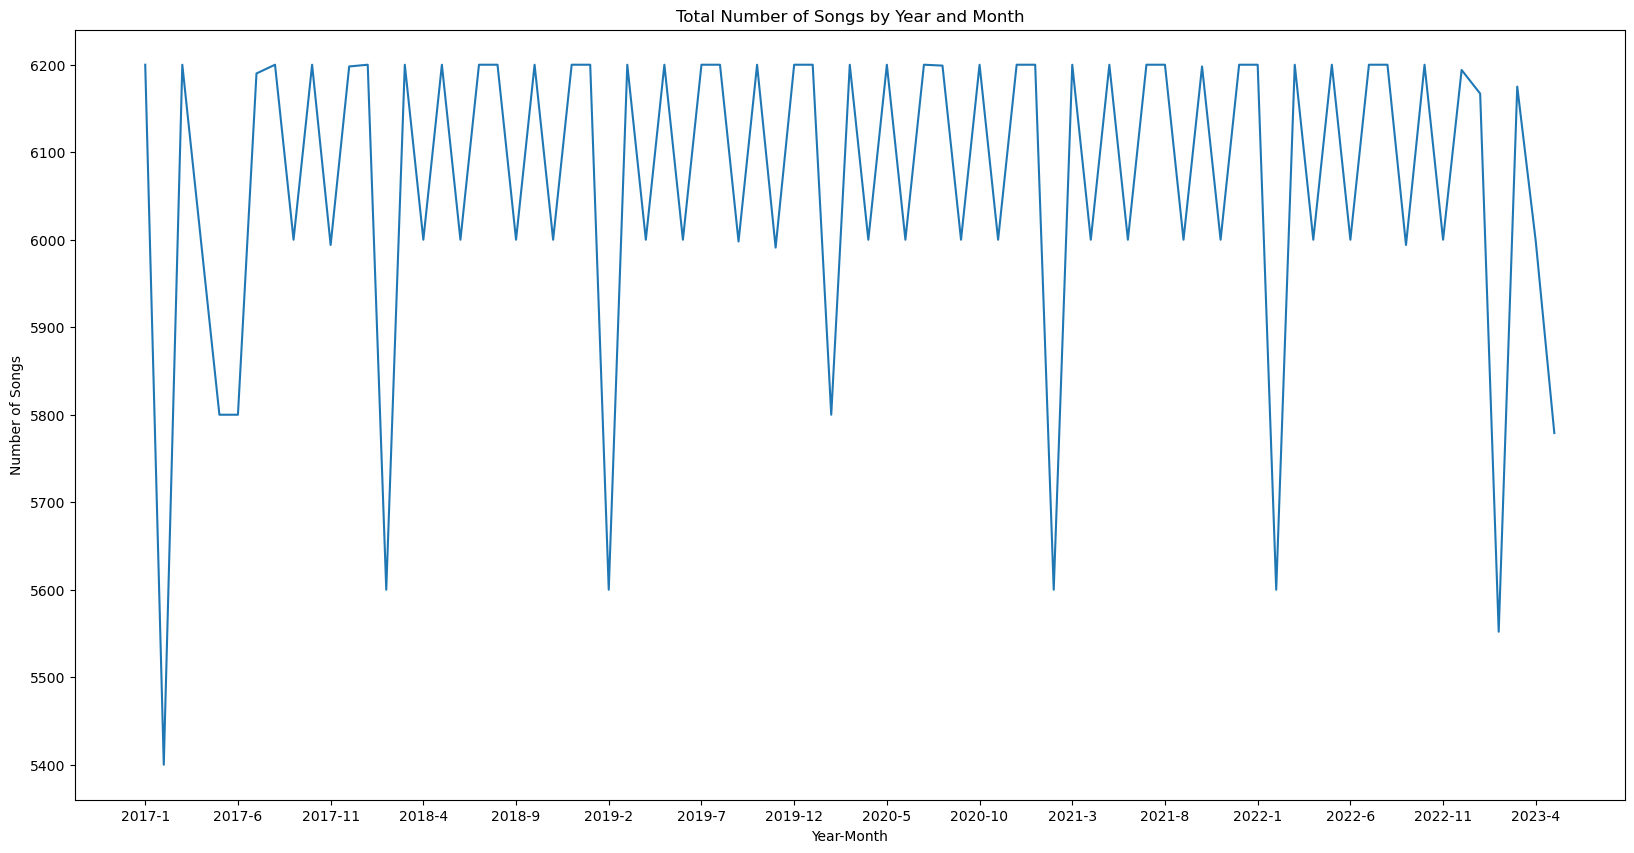

,Number of Songs,Year-Month
67,6200,2022-8
68,5994,2022-9
69,6200,2022-10
70,6000,2022-11
71,6194,2022-12
72,6167,2023-1
73,5552,2023-2
74,6175,2023-3
75,5998,2023-4
76,5779,2023-5


In [25]:
# time series visualization
# plot the total number of songs by year and month
# group by year and month
line_graph_sum = song_data_region.groupby(['Year', 'Month']).size().reset_index(name='Number of Songs')

# combine year and month
line_graph_sum['Year-Month'] = line_graph_sum['Year'].astype(str) + '-' + line_graph_sum['Month'].astype(str)
line_graph_data = line_graph_sum.drop(columns=['Year', 'Month'])
line_graph_data.tail(10)
# plot the line graph
plt.figure(figsize=(20, 10))
x = line_graph_data['Year-Month']
y = line_graph_data['Number of Songs']
plt.plot(x, y)
plt.xticks(x[::5])
plt.xlabel('Year-Month')
plt.ylabel('Number of Songs')
plt.title('Total Number of Songs by Year and Month')
plt.show()
line_graph_data.tail(10)

### Analyse points of different regions over time
In visualisation stage, we can not see any relations between the popularity of music in one continent and the popularity of music in other continents as we lack of information about that song in other continent For the time trend in terms of daily points, we can see that the average points across each day is quite stable, we can not make a conclusion that the popularity of music will increase or decrease in specific time period

### Analyse the user's streams over time
In the graph and data, we extract top 30% of the average score in that month. We assume that if the average score of the songs is high, it means that the user to spend longer time to listen to the user. We can see that there is lower average score in Month 1,2,9,12. So the average song quality maynot be good in these months. This could be an indicator that the user may not spend longer time to listen to the user. In 3, 6, 7, 10, 11, the average score is higher and that could increase the opportunity for the user to spend longer time to listen to the music. Publishing the music in these months could be a good choice.

Before removing outliers:  (27135, 5)
After removing outliers:  (7025, 5)


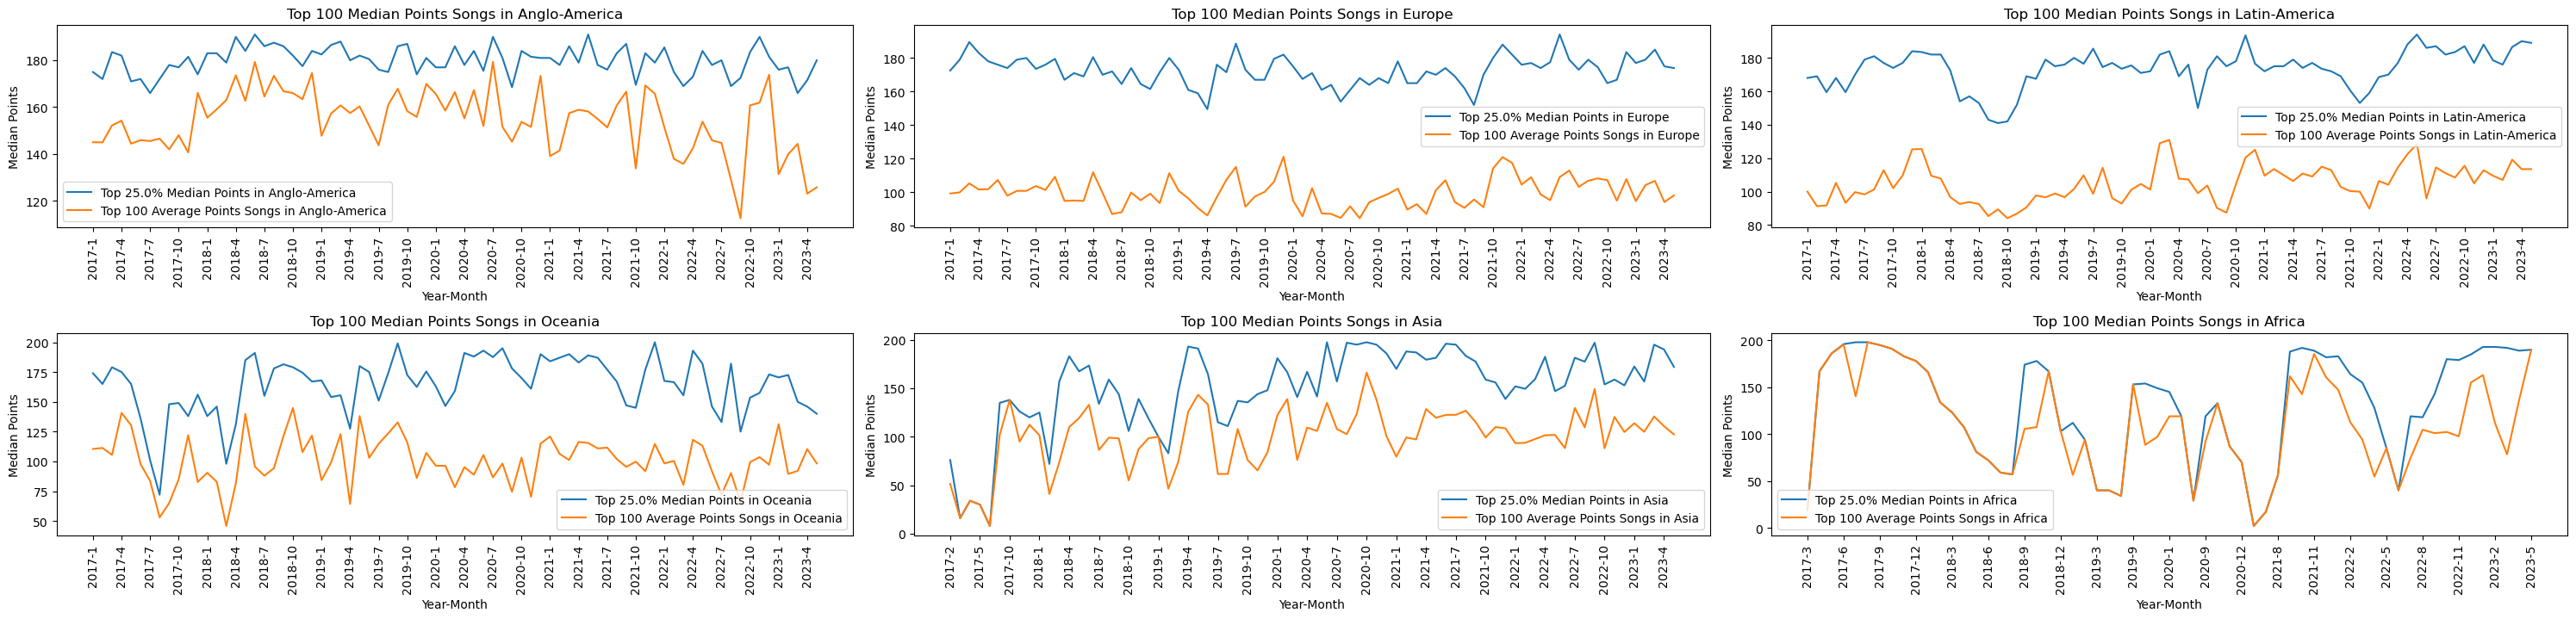

Before removing outliers:  (27135, 5)
After removing outliers:  (7025, 5)


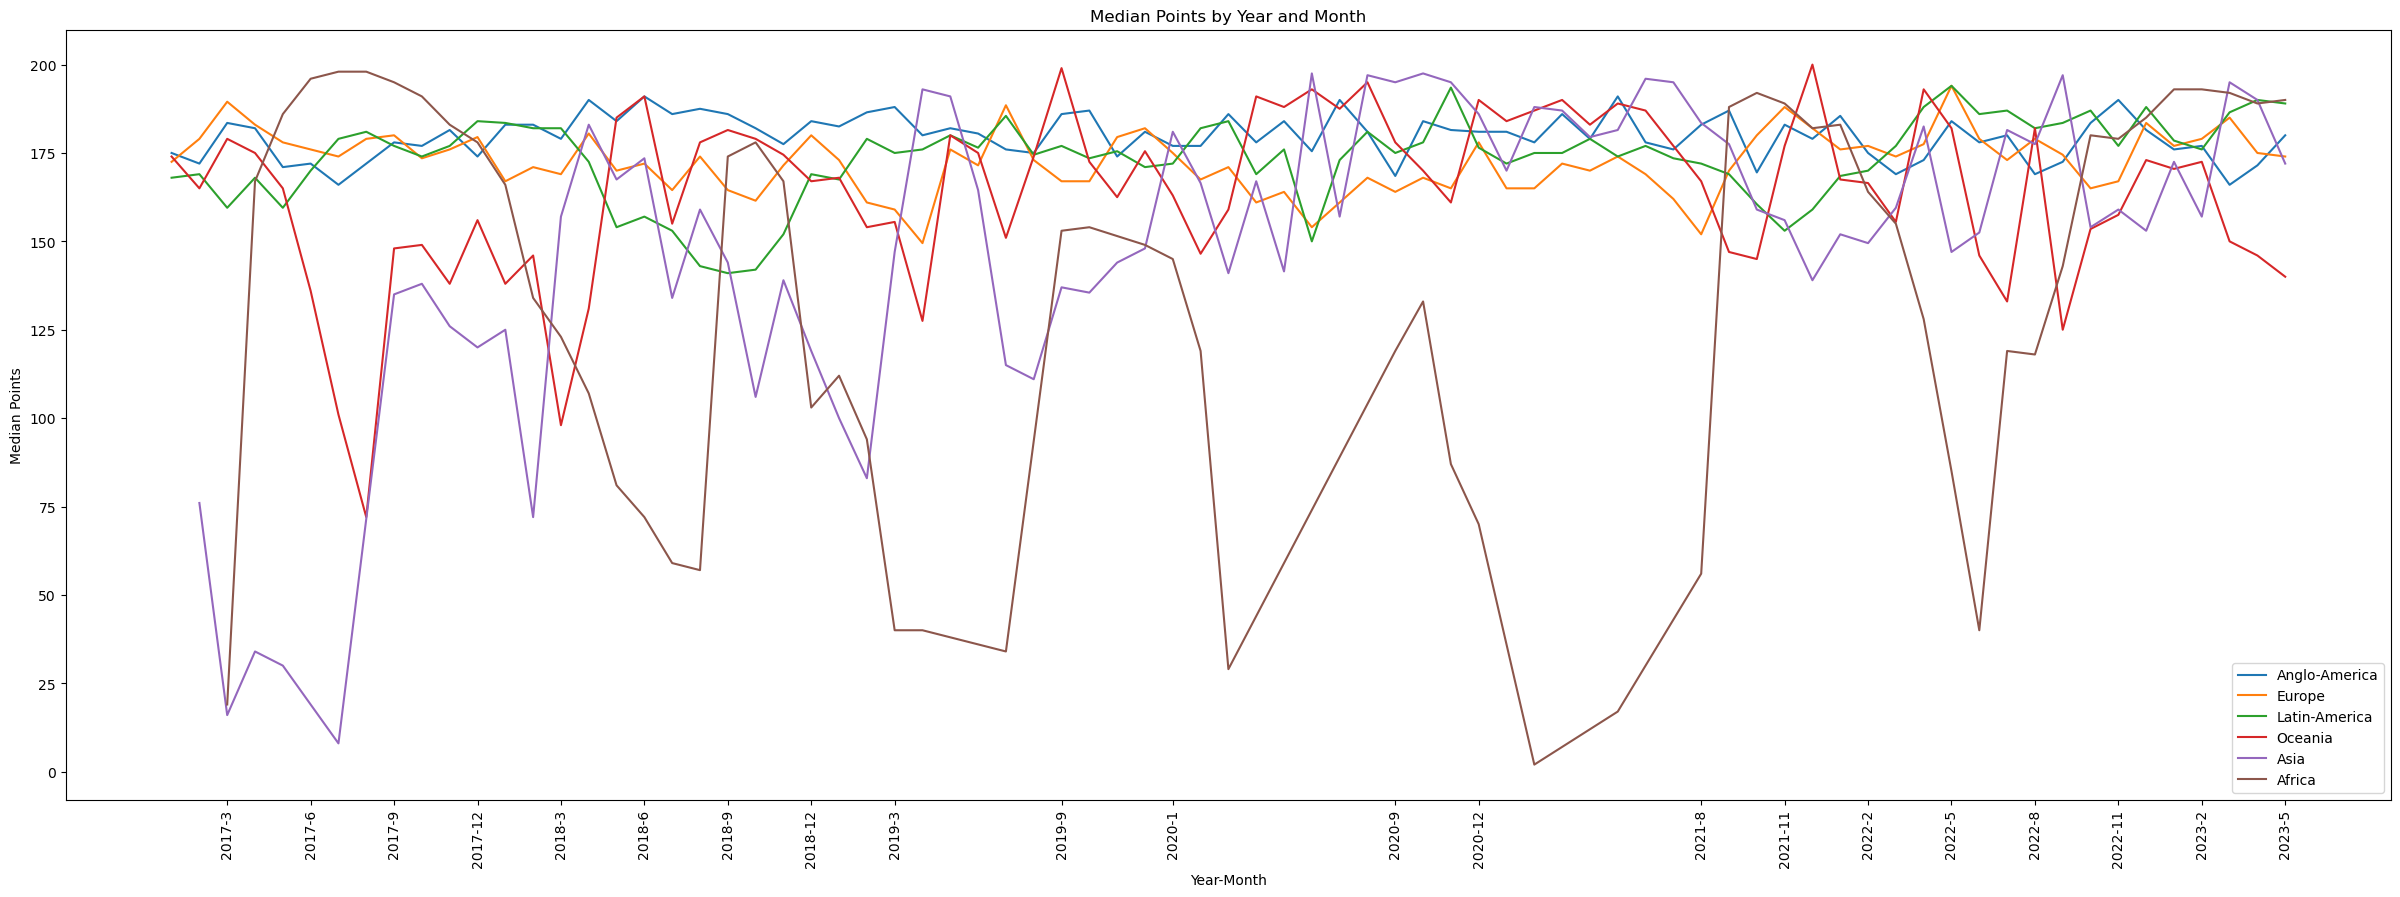

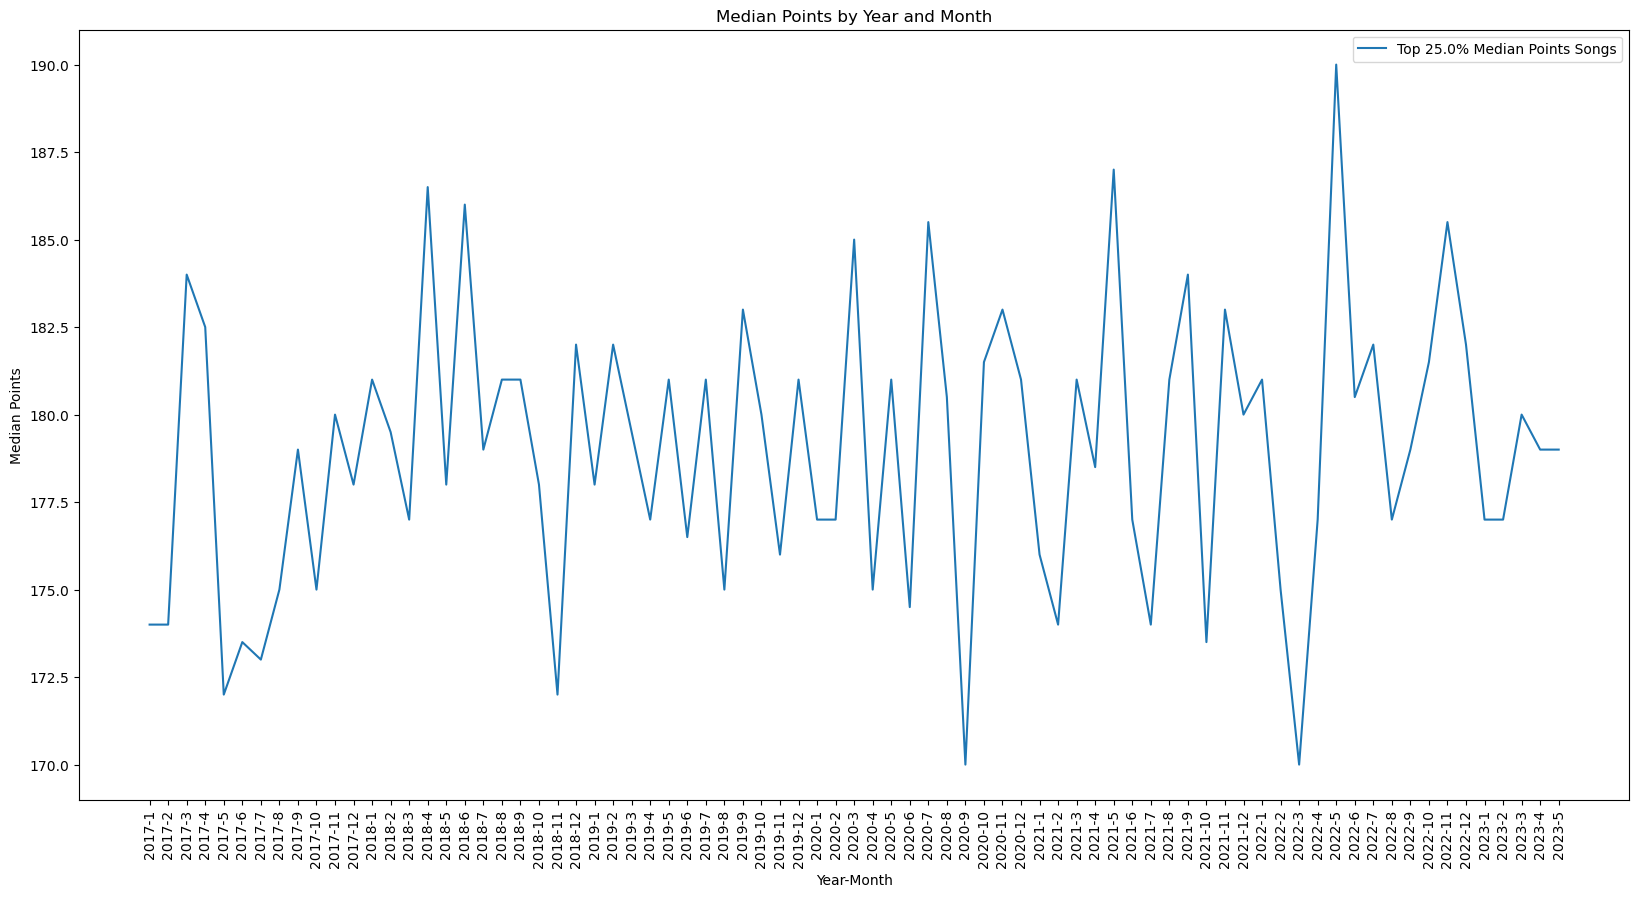

,Median Points,Year,Month
71,182.0,2022,12
70,185.5,2022,11
69,181.5,2022,10
66,182.0,2022,7
64,190.0,2022,5
60,181.0,2022,1
58,183.0,2021,11
56,184.0,2021,9
55,181.0,2021,8
52,187.0,2021,5


Month,Count
1,2
2,1
3,3
4,2
5,4
6,1
7,3
8,2
9,3
10,2


In [26]:
class Mode(Enum):
    MEAN: str = 'Average Points'
    MEDIAN: str = 'Median Points'
    SUM: str = 'Total Points'

class GraphType(Enum):
    SUBPLOTS: str = 'Subplots'
    ONE_PLOT: str = 'One Plot'

# grab top n average points of the songs in each continent in each year and month
def top_n_song_points(data: pd.DataFrame, n: int = 10):
    region_points = song_data_region.groupby(['Year', 'Month', 'Continent', 'id'])['Points (Total)'].max()
    region_points_df = region_points.reset_index(name='Max Points')
    top_n_songs_points = region_points_df.sort_values(by=['Year', 'Month', 'Continent', 'Max Points'], ascending=False)
    top_n_songs_points = top_n_songs_points.groupby(['Year', 'Month', 'Continent']).head(n)
    top_n_songs_points = top_n_songs_points.reset_index(drop=True)
    return top_n_songs_points

def line_graph_for_time_series(data: pd.DataFrame, mode = Mode.MEAN, outlier_percent: float = 0.25, xticks_interval: int = 5, day: bool = False, date_point_quantile: float = 0.0):
    group_by_columns = ['Year', 'Month'] if not day else ['Year', 'Month', 'Day']
    merged_time_column = 'Year-Month' if not day else 'Year-Month-Day'
    # create a data with year, month and the max points of the song in each continent in each year and month
    line_graph_points = data.groupby(group_by_columns + ['id'])['Points (Total)'].max()
    line_graph_points = line_graph_points.reset_index(name='Max Points')
    # drop last outlier_percent of the points in each year and month to remove outliers
    line_graph_points = line_graph_points.sort_values(by=group_by_columns + ['Max Points'], ascending=False)
    point_threshold = line_graph_points.groupby(group_by_columns)['Max Points'].quantile(outlier_percent)
    line_graph_points = line_graph_points.merge(point_threshold, on=group_by_columns, suffixes=('', '_threshold'))
    line_graph_points = line_graph_points[line_graph_points['Max Points'] >= line_graph_points['Max Points_threshold']]
    line_graph_points = line_graph_points.drop(columns=['Max Points_threshold'])
    line_graph_points = line_graph_points.reset_index(drop=True)
    line_graph_points = line_graph_points.groupby(group_by_columns)['Max Points']
    
    if mode == Mode.MEAN:
        line_graph_points = line_graph_points.mean()
    elif mode == Mode.MEDIAN:
        line_graph_points = line_graph_points.median()
    elif mode == Mode.SUM:
        line_graph_points = line_graph_points.sum()
    
    line_graph_points = line_graph_points.reset_index(name= mode.value)
    if not day:
        line_graph_points['Year-Month'] = line_graph_points['Year'].astype(str) + '-' + line_graph_points['Month'].astype(str)
    else:
        line_graph_points['Year-Month-Day'] = line_graph_points['Year'].astype(str) + '-' + line_graph_points['Month'].astype(str) + '-' + line_graph_points['Day'].astype(str)
    line_graph_points = line_graph_points.drop(columns=group_by_columns)
    
    plt.figure(figsize=(20, 10))
    x = line_graph_points[merged_time_column]
    y = line_graph_points[mode.value]
    plt.plot(x, y, label=f'Top {100 - outlier_percent*100}% {mode.value} Songs')
    plt.xticks(x[::xticks_interval], rotation=90)
    plt.xlabel(str(merged_time_column))
    plt.ylabel(mode.value)
    title = f'{mode.value} by Year and Month' if not day else f'{mode.value} by Year, Month and Day'
    plt.title(f'{title}')
    plt.legend()
    plt.show()
    
    # print the time which is top 20% of the points in each year and month
    top_10_percent_points_time_period = line_graph_points[line_graph_points[mode.value] >= line_graph_points[mode.value].quantile(date_point_quantile)]

    # split the year-month column into year and month
    top_10_percent_points_time_period[group_by_columns] = top_10_percent_points_time_period[merged_time_column].str.split('-', expand=True)
    top_10_percent_points_time_period = top_10_percent_points_time_period.drop(columns=[merged_time_column])
    # change all the columns in group_by_columns to int
    top_10_percent_points_time_period[group_by_columns] = top_10_percent_points_time_period[group_by_columns].astype(int)
    # sort by year and month
    top_10_percent_points_time_period = top_10_percent_points_time_period.sort_values(by=group_by_columns, ascending=False)
    display(pd.DataFrame(top_10_percent_points_time_period))
    # count the number of same month or (year) in current record
    if not day:
        # group the record by month and conunt the number of same month, keep month, and count only
        top_10_percent_points_time_period = top_10_percent_points_time_period.groupby(group_by_columns[1]).size().reset_index(name='Count')
        display(pd.DataFrame(top_10_percent_points_time_period).style.hide_index())
        

def line_graph_for_continents(data: pd.DataFrame, mode = Mode.MEAN, graph_type = GraphType.SUBPLOTS, outlier_percent: float = 0.25, n: int = -1, xticks_interval: int = 5):
    assert 0 <= outlier_percent <= 1, 'outlier_percent must be between 0 and 1'
    # create a data with year, month, continent and the max points of the song in each continent in each year and month
    line_graph_region_points = data.groupby(['Year', 'Month', 'Continent', 'id'])['Points (Total)'].max()
    line_graph_region_points = line_graph_region_points.reset_index(name='Max Points')
    print("Before removing outliers: ", line_graph_region_points.shape)
    # drop last 25% of the points in each continent in each year and month to remove outliers
    line_graph_region_points = line_graph_region_points.sort_values(by=['Year', 'Month', 'Continent', 'Max Points'], ascending=False)
    point_threshold = line_graph_region_points.groupby(['Year', 'Month', 'Continent'])['Max Points'].quantile(outlier_percent)
    line_graph_region_points = line_graph_region_points.merge(point_threshold, on=['Year', 'Month', 'Continent'], suffixes=('', '_threshold'))
    line_graph_region_points = line_graph_region_points[line_graph_region_points['Max Points'] >= line_graph_region_points['Max Points_threshold']]
    line_graph_region_points = line_graph_region_points.drop(columns=['Max Points_threshold'])
    line_graph_region_points = line_graph_region_points.reset_index(drop=True)
    print("After removing outliers: ", line_graph_region_points.shape)
    line_graph_region_points = line_graph_region_points.groupby(['Year', 'Month', 'Continent'])['Max Points']
    
    if mode == Mode.MEAN:
        line_graph_region_points = line_graph_region_points.mean()
    elif mode == Mode.MEDIAN:
        line_graph_region_points = line_graph_region_points.median()
    elif mode == Mode.SUM:
        line_graph_region_points = line_graph_region_points.sum()
    line_graph_region_points = line_graph_region_points.reset_index(name= mode.value)
    line_graph_region_points['Year-Month'] = line_graph_region_points['Year'].astype(str) + '-' + line_graph_region_points['Month'].astype(str)
    line_graph_region_points = line_graph_region_points.drop(columns=['Year', 'Month'])
    if graph_type == GraphType.SUBPLOTS:
        # plot the multiple line graph for each continent in each subplot
        plt.figure(figsize=(30, 10))
        for i, continent in enumerate(line_graph_region_points['Continent'].unique(), 1):
            plt.subplot(3, 3, i)
            x = line_graph_region_points[line_graph_region_points['Continent'] == continent]['Year-Month']
            y = line_graph_region_points[line_graph_region_points['Continent'] == continent][mode.value]
            plt.plot(x, y, label=f'Top {100 - outlier_percent*100}% {mode.value} in {continent}')
            plt.xticks(x[::xticks_interval], rotation=90)
            if n != -1:
                plt.title(f'Top {n} {mode.value} Songs in {continent}')
                top_n_songs_points = top_n_song_points(data, n)
                top_n_songs_points = top_n_songs_points.groupby(['Year', 'Month', 'Continent'])['Max Points'].mean()
                top_n_songs_points = top_n_songs_points.reset_index(name='Average Points')
                top_n_songs_points['Year-Month'] = top_n_songs_points['Year'].astype(str) + '-' + top_n_songs_points['Month'].astype(str)
                top_n_songs_points = top_n_songs_points.drop(columns=['Year', 'Month'])
                plt.plot(top_n_songs_points[top_n_songs_points['Continent'] == continent]['Year-Month'], 
                         top_n_songs_points[top_n_songs_points['Continent'] == continent]['Average Points'], 
                         label=f'Top {n} Average Points Songs in {continent}')
            else:
                plt.title(f'{mode.value} by Year and Month in {continent}')
            plt.xlabel('Year-Month')
            plt.ylabel(mode.value)
            plt.legend()
            
        plt.tight_layout()
        plt.show()
    elif graph_type == GraphType.ONE_PLOT:
        # plot another line graph for each continent in one plot
        plt.figure(figsize=(30, 10))
        for continent in line_graph_region_points['Continent'].unique():
            x = line_graph_region_points[line_graph_region_points['Continent'] == continent]['Year-Month']
            y = line_graph_region_points[line_graph_region_points['Continent'] == continent][mode.value]
            plt.plot(x, y, label=continent)
            plt.xticks(x[::xticks_interval], rotation=90)
        plt.xlabel('Year-Month')
        plt.ylabel(mode.value)
        plt.title(f'{mode.value} by Year and Month')
        plt.legend()
        plt.show()


line_graph_for_continents(song_data_region, mode=Mode.MEDIAN, graph_type=GraphType.SUBPLOTS, outlier_percent=0.75, n=100, xticks_interval=3)
line_graph_for_continents(song_data_region, mode=Mode.MEDIAN, graph_type=GraphType.ONE_PLOT, outlier_percent=0.75, n=100, xticks_interval=3)
# line_graph_for_time_series(song_data_region, mode=Mode.MEAN, outlier_percent=0.75, xticks_interval=30, day=True)
line_graph_for_time_series(song_data_region, mode=Mode.MEDIAN, outlier_percent=0.75, xticks_interval=1, date_point_quantile=0.7)

## Visualize the result (song)

### Distribution of song attributes
For loudness, it has great range of values so it should be handled by normalization. For instrumentalness, it has a lot of 0 values and does not contain much information. For Danceability and Energy, Speechiness and Acousticness, they have similar shape of distribution and they could be correlated.

Before removing outliers:  (9161, 8)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


After removing outliers:  (8703, 8)


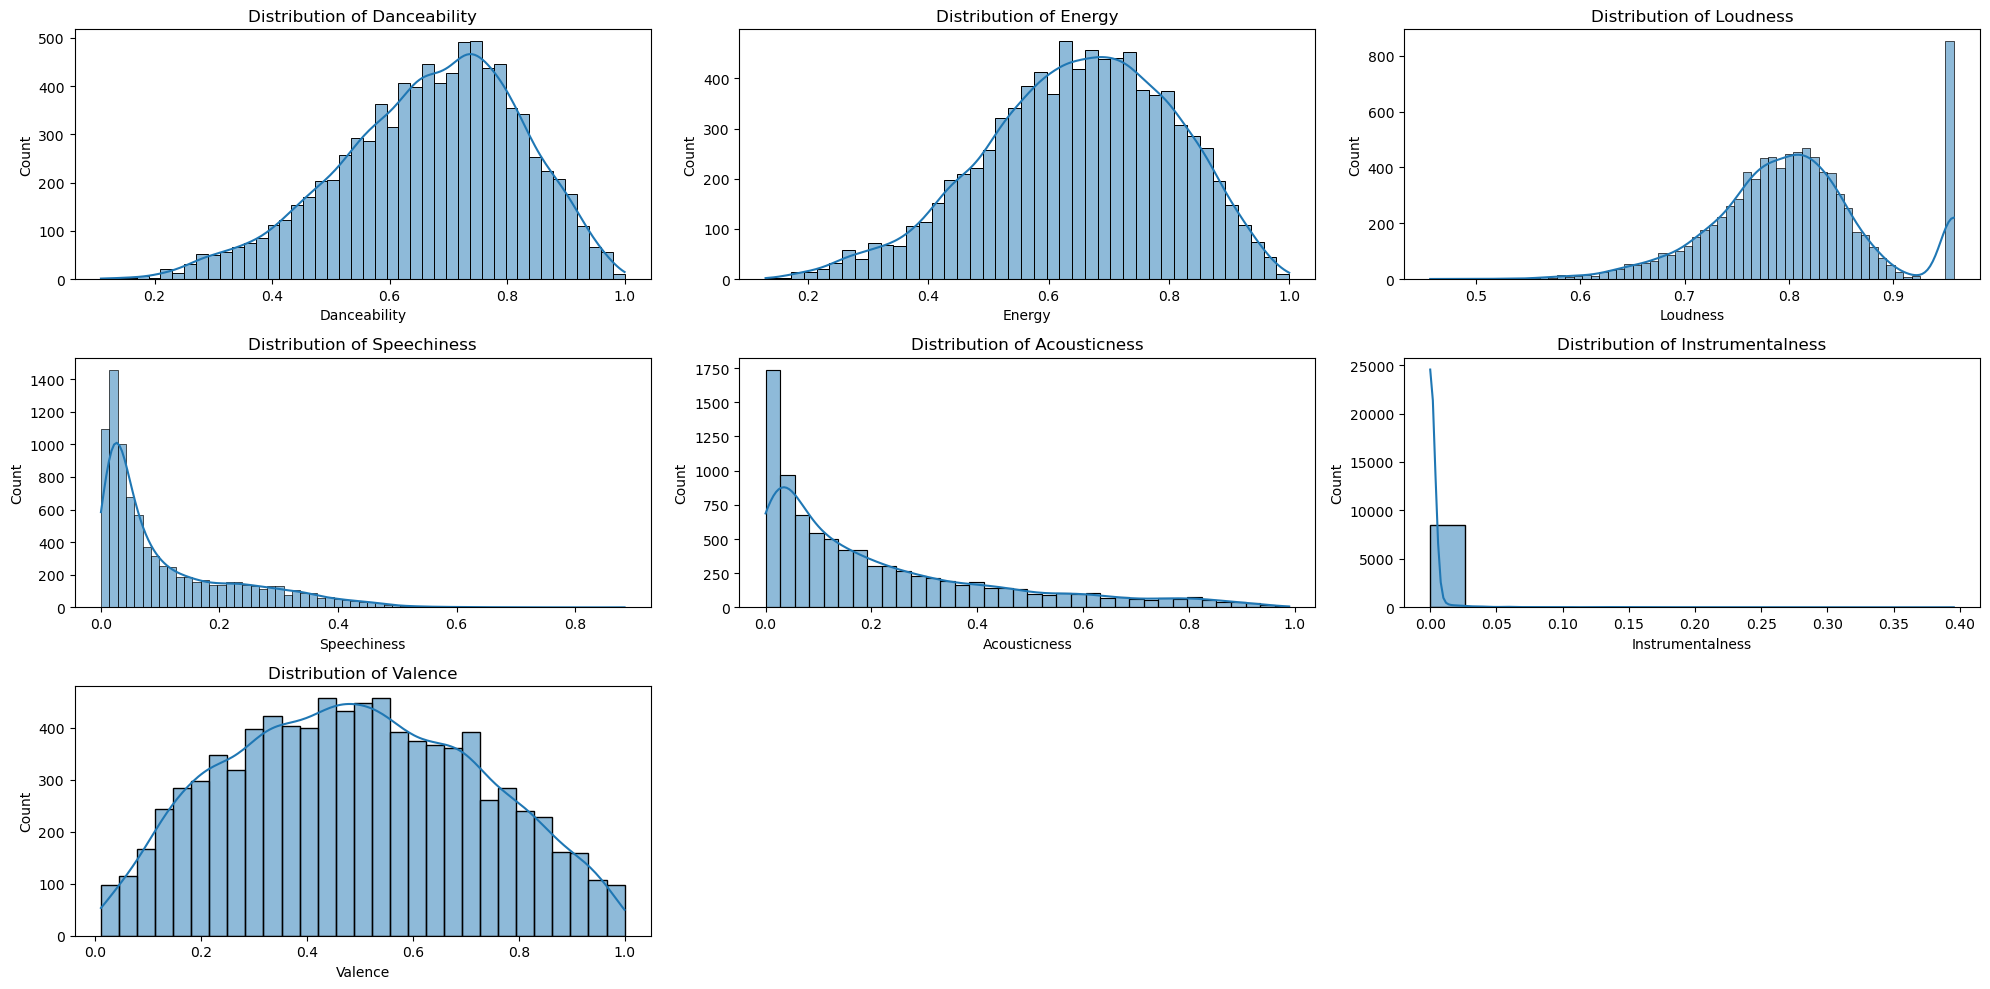

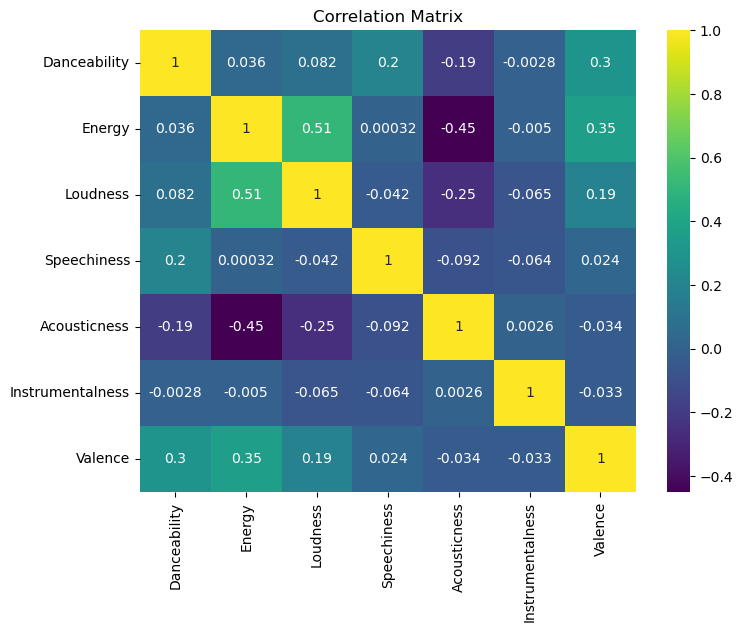

In [27]:
song_attributes = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence']

def plot_distribution(data: pd.DataFrame, columns: list = song_attributes):

    # plot the distribution of each song attribute in subplots
    plt.figure(figsize=(20, 10))
    for i, attribute in enumerate(columns, 1):
        plt.subplot(3, 3, i)
        sns.histplot(data=data, x=attribute, kde=True)
        plt.title(f'Distribution of {attribute}')
    plt.tight_layout()
    plt.show()
    
def plot_correlation(data: pd.DataFrame):
    # plot the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(data.corr(), annot=True, cmap='viridis')
    plt.title('Correlation Matrix')
    plt.show()
    

def normalize(data: pd.DataFrame, columns: list = song_attributes):
    # normalize the data
    scaler = MinMaxScaler()
    data[columns] = scaler.fit_transform(data[columns])
    return data

def remove_outliers(data: pd.DataFrame, columns: list = song_attributes):
    model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.05), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=1)
    model.fit(data[columns])
    data['anomaly'] = pd.Series(model.predict(data[columns]))
    data = data[data['anomaly'] == 1]
    data = data.drop(columns=['anomaly'])
    data.reset_index(drop=True, inplace=True)
    return data
    
    
normalized_data = normalize(song_data_only, song_attributes)
print("Before removing outliers: ", normalized_data.shape)
cleaned_song_data = remove_outliers(normalized_data, song_attributes)
print("After removing outliers: ", cleaned_song_data.shape)
plot_distribution(cleaned_song_data, song_attributes)
plot_correlation(cleaned_song_data)

refined_song_attributes = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Valence']

### PCA dimensionality reduction

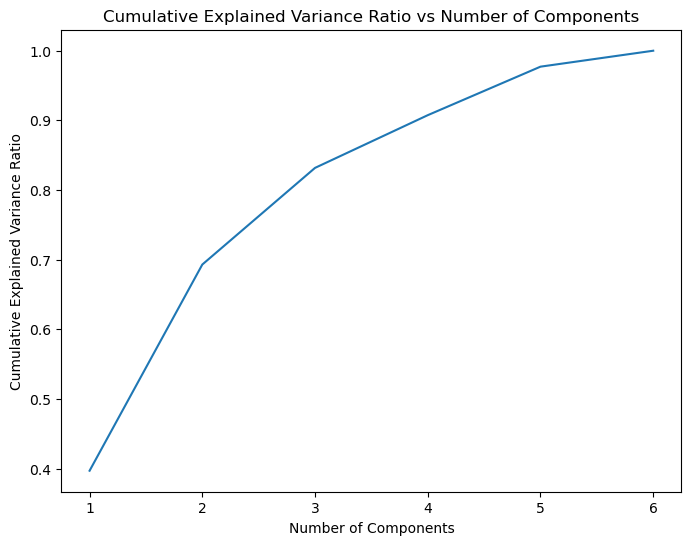

Knee Point: 3
Explained Variance Ratio: 0.8318100854046961


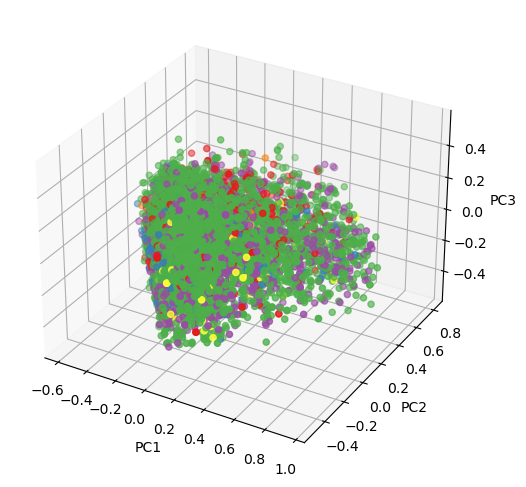

,PC1,PC2,PC3
0,-0.109859,0.425989,-0.147621
1,-0.019655,0.068086,0.260904
2,-0.017048,0.344037,0.057044
3,-0.038543,0.040553,-0.174356
4,-0.211390,-0.001281,-0.018469


In [28]:
# pca
def pca(data: pd.DataFrame, target_columns: list = song_attributes, n_components: int = 2):
    pca = PCA(n_components=n_components)

    pca_data = pca.fit_transform(data[target_columns])

    pca_data = pd.DataFrame(pca_data, columns=[f'PC{i}' for i in range(1, n_components+1)])
    return pca_data
    
def get_knee_n(data: pd.DataFrame, target_columns: list = song_attributes):
    number_of_components = len(target_columns)
    pca = PCA(n_components=number_of_components)
    pca.fit_transform(data[target_columns])
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    # plot the cumulative variance ratio
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio vs Number of Components')
    plt.show()
    
    kn = KneeLocator(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, curve='concave', direction='increasing')
    print(f'Knee Point: {kn.knee}')
    print(f'Explained Variance Ratio: {cumulative_variance_ratio[kn.knee-1]}')
    return kn.knee

def plot_pca_graph(pca_data: pd.DataFrame, data: pd.DataFrame, label_column: str = 'Continent', n_components: int = 2):
    # plot 3d scatter plot
    if n_components == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        # map the continent into colors
        color_map = ListedColormap(plt.cm.Set1.colors[:len(data[label_column].unique())])
        ax.scatter(pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], c=data[label_column].map({continent: i for i, continent in enumerate(data[label_column].unique())}), cmap=color_map)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        plt.show()
        
        
    

n = get_knee_n(cleaned_song_data, refined_song_attributes)
pca_data = pca(cleaned_song_data, refined_song_attributes, n_components=n)
plot_pca_graph(pca_data, cleaned_song_data, label_column='Continent', n_components=n)
pca_data.head()


## Song genre classification
1. Label them with clusters (Failed)
2. Train models for classification

### Clustering

KMEANS:
Number of Clusters: 3
Silhouette Score: 0.3275839637360091
Davies Bouldin Score: 1.0621302261389547

DBSCAN:
Best Silhouette Score:  0.38574756612553013  Best Davies Bouldin Score:  0.5332216963398735
eps:  0.15  min_samples:  11
Number of Clusters:  2

Number of Clusters:  2
Silhouette Score: 0.30942188038331087
Davies Bouldin Score: 1.3464118389346242

As a result, the song attributes are not good enough to cluster the songs into different genres. The silhouette score is not high enough to cluster the songs into different genres. The reason could be that there are many overlapping in different sets of songs. For example, the songs in the genre of pop could be similar to the songs in the genre of rock. So it is hard to cluster the songs into different genres.

In [29]:
def kmeans_clustering(pca_data: pd.DataFrame, data: pd.DataFrame):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(pca_data)
        wcss.append(kmeans.inertia_)
    # plot the elbow method
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 11), wcss)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    
    kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
    kmeans = KMeans(n_clusters=kn.knee, init='k-means++', random_state=42)
    print(f'Number of Clusters: {kn.knee}')
    kmeans.fit(pca_data)
    
    silhouette_avg = silhouette_score(pca_data, kmeans.labels_)
    print(f'Silhouette Score: {silhouette_avg}')
    davies_bouldin = davies_bouldin_score(pca_data, kmeans.labels_)
    print(f'Davies Bouldin Score: {davies_bouldin}')
    
    # add the cluster column to the data
    new_data = data.copy()
    new_data['Genre'] = kmeans.labels_
    
    
    return new_data

def dbscan_clustering(pca_data: pd.DataFrame, data: pd.DataFrame):
    eps_values = [0.13, 0.14, 0.15, 0.16, 0.17]
    min_samples_values = [11, 12, 13]
    silhouette_avg_values = []
    davies_bouldin_values = []
    cluster_numbers = []
    selected_eps_val = 0
    selected_sample_val = 0
    max_silhouette_avg = 0
    max_davies_bouldin = 0
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(pca_data)
            if len(set(clusters)) == 1:
                silhouette_avg_values.append(-1)
                davies_bouldin_values.append(-1)
                cluster_numbers.append(1)
            else:
                silhouette_avg_values.append(silhouette_score(pca_data, clusters))
                
                davies_bouldin_values.append(davies_bouldin_score(pca_data, clusters))
                cluster_numbers.append(len(set(clusters)))
                if len(silhouette_avg_values) == 1:
                    selected_eps_val = eps
                    selected_sample_val = min_samples
                    max_silhouette_avg = silhouette_avg_values[-1]
                    max_davies_bouldin = davies_bouldin_values[-1]
                elif silhouette_avg_values[-1] > max_silhouette_avg and davies_bouldin_values[-1] < max_davies_bouldin:
                    max_silhouette_avg = silhouette_avg_values[-1]
                    max_davies_bouldin = davies_bouldin_values[-1]
                    selected_eps_val = eps
                    selected_sample_val = min_samples
    
    # plot the silhouette score
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(silhouette_avg_values)), silhouette_avg_values)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()
    
    selected_index = np.argmax(silhouette_avg_values)
    dbscan = DBSCAN(eps=selected_eps_val, min_samples=selected_sample_val)
    
    print("Best Silhouette Score: ", max_silhouette_avg, " Best Davies Bouldin Score: ", max_davies_bouldin)
    print('eps: ', selected_eps_val, ' min_samples: ', selected_sample_val)
    print("Number of Clusters: ", cluster_numbers[selected_index])
    
    new_data = data.copy()
    new_data['Genre'] = dbscan.fit_predict(pca_data)
    return new_data

def hierarchical_clustering(pca_data: pd.DataFrame, data: pd.DataFrame):
    hierarchical = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
    labels = hierarchical.fit_predict(pca_data)
    
    print("Number of Clusters: ", len(set(labels)))
    silhouette_avg = silhouette_score(pca_data, labels)
    print(f'Silhouette Score: {silhouette_avg}')
    davies_bouldin = davies_bouldin_score(pca_data, labels)
    print(f'Davies Bouldin Score: {davies_bouldin}')
    
    new_data = data.copy()
    new_data['Genre'] = labels
    
    return new_data
    
# song_data_with_genre = dbscan_clustering(pca_data, cleaned_song_data)
# song_data_with_genre = kmeans_clustering(pca_data, cleaned_song_data)
song_data_with_genre = hierarchical_clustering(pca_data, cleaned_song_data)
# song_data_with_genre.head()

Number of Clusters:  2
Silhouette Score: 0.30942188038332585
Davies Bouldin Score: 1.3464118389346234


#### Time series analysis

##### Visualize the number of points of different months

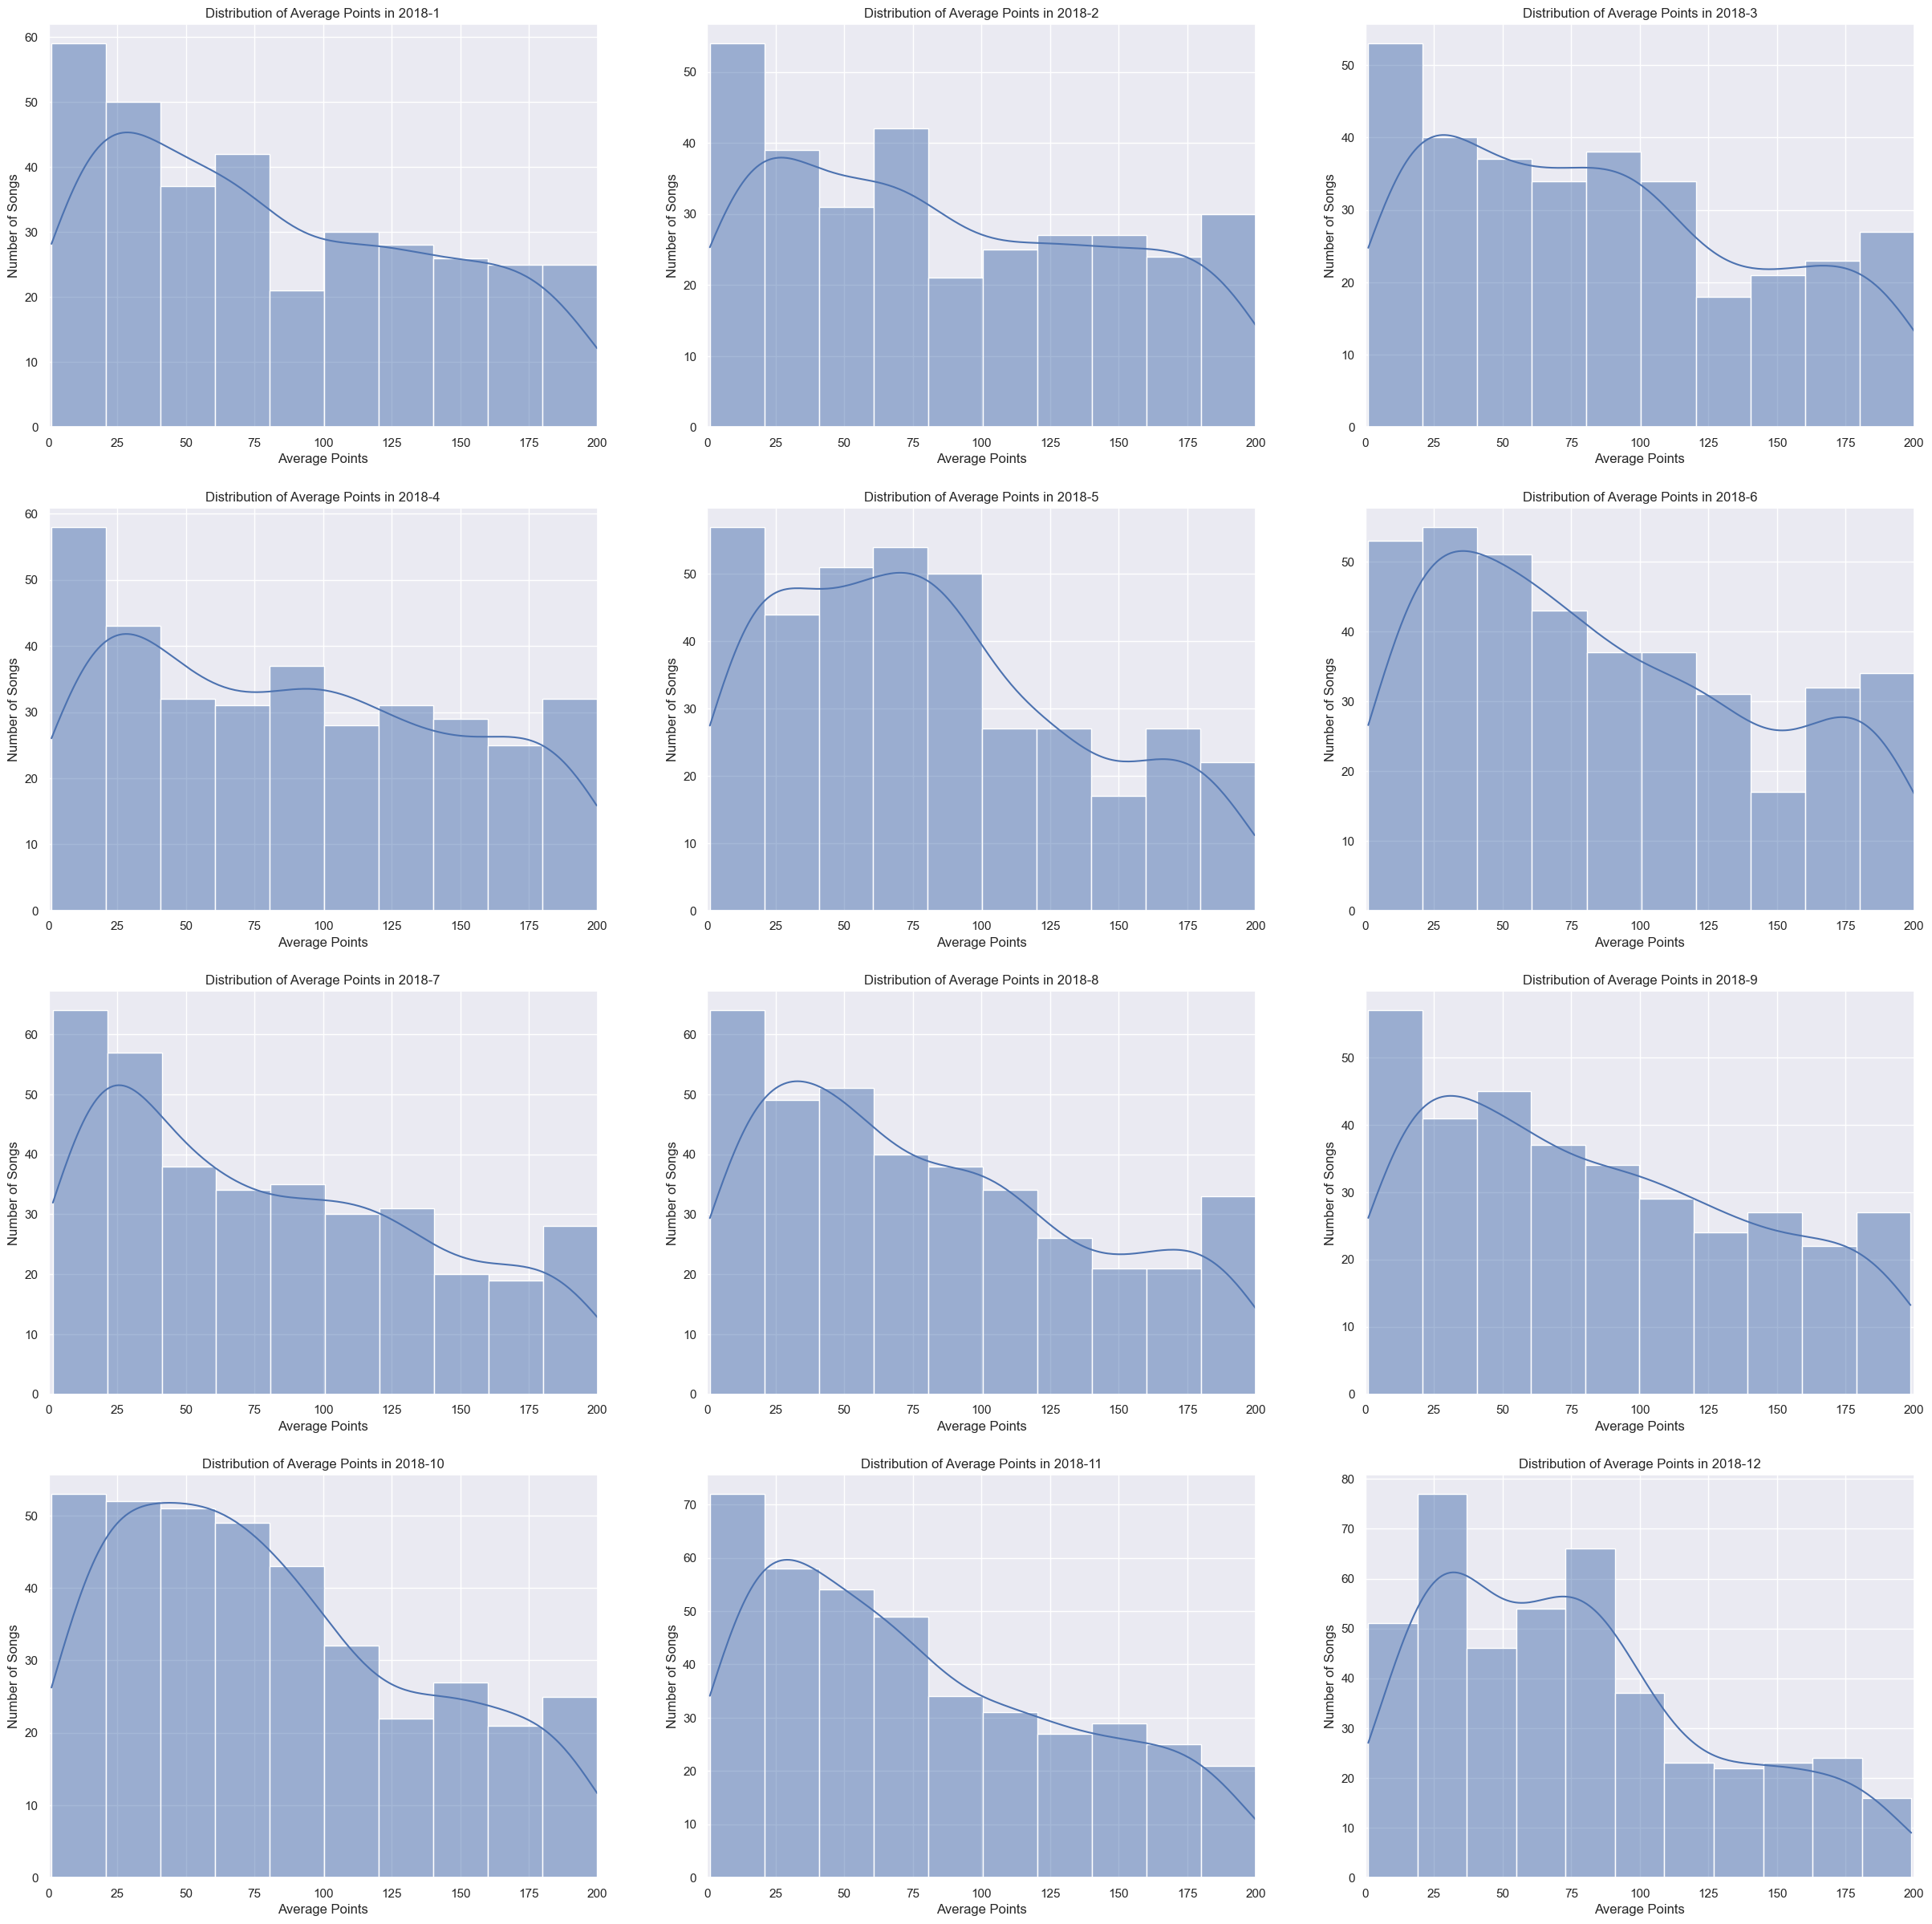

In [30]:
# plot distribution graph for each year and month versus score
def plot_distribution_graph_for_year_month(song_data_region: pd.DataFrame, year: int, month: int):
    data = song_data_region.groupby(['Year', 'Month', 'Continent', 'id'])['Points (Total)'].mean()
    data = data.reset_index(name='Average Points')
    mean = data[(data['Year'] == year) & (data['Month'] == month)]['Average Points'].mean()
    median = data[(data['Year'] == year) & (data['Month'] == month)]['Average Points'].median()
    std = data[(data['Year'] == year) & (data['Month'] == month)]['Average Points'].std()
    q1 = data[(data['Year'] == year) & (data['Month'] == month)]['Average Points'].quantile(0.25)
    q3 = data[(data['Year'] == year) & (data['Month'] == month)]['Average Points'].quantile(0.75)
    
    plt.figure(figsize=(20, 10))
    sns.displot(data[(data['Year'] == year) & (data['Month'] == month)]['Average Points'], kde=True)
    plt.xlim(0, 200)
    plt.xlabel('Average Points')
    plt.ylabel('Number of Songs')
    plt.title(f'Distribution of Average Points in {year}-{month}')
    # legend the mean, median and standard deviation
    plt.axvline(mean, color='red', label='Mean')
    plt.axvline(median, color='green', label='Median')
    plt.axvline(q1, color='purple', label='Q1')
    plt.axvline(q3, color='purple', label='Q3')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

    display(pd.DataFrame({'Mean': [mean], 'Median': [median], 'Standard Deviation': [std], 'Q1': [q1], 'Q3': [q3]}))

def plot_distribution_graph_for_year(song_data_region: pd.DataFrame, year: int):
    sns.set()
    data = song_data_region.groupby(['Year', 'Month', 'Continent', 'id'])['Points (Total)'].mean()
    data = data.reset_index(name='Average Points')

    fig, axes = plt.subplots(4, 3, figsize=(30, 30))
    for i, month in enumerate(range(1, 13), 1):
        sub_data = data[(data['Year'] == year) & (data['Month'] == month)]['Average Points']
        sns.histplot(sub_data, kde=True, ax=axes[(i-1)//3, (i-1)%3])
        axes[(i-1)//3, (i-1)%3].set_xlim(0, 200)
        axes[(i-1)//3, (i-1)%3].set_xlabel('Average Points')
        axes[(i-1)//3, (i-1)%3].set_ylabel('Number of Songs')
        axes[(i-1)//3, (i-1)%3].set_title(f'Distribution of Average Points in {year}-{month}')
    plt.show()
    
plot_distribution_graph_for_year(song_data_region, 2018)

对歌曲去重，在数据集中，大部分音乐由于有多个Artist导致重复出现，我们把有多个Artist的歌曲（即重复歌曲）去除
因为数据集是每日的排行榜数据，所以许多歌曲会重新上榜，我们根据去除掉重复歌曲的全部的数据进行处理，取每一首歌的最大值/平均值进行

In [31]:
# 假设 'df' 是您的DataFrame名称
# 1. 将 'Date' 列转换为 datetime 对象，以确保正确处理
spotify_song_data['Date'] = pd.to_datetime(spotify_song_data['Date'], format='%d/%m/%Y')  # 调整 format 以匹配您的实际日期格式

# 2. 删除具有相同 'Title' 和 'Date' 但 'Artists' 不同的重复项
df_unique = spotify_song_data.drop_duplicates(subset=['Title', 'Date'])

# 3. 如果需要，可以重置索引
df_unique.reset_index(drop=True, inplace=True)

# 显示更新后的DataFrame
df_unique.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Continent_Anglo-America,Continent_Asia,Continent_Europe,Continent_Latin-America,Continent_Oceania,Continent_Unknown,Artist_Total_Points,Year,Month,Popular
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,0,0,0,1,0,0,1.081600e+04,2023,5,1
1,2,WHERE SHE GOES,Bad Bunny,2023-05-29,0.652,0.800,-4019.0,0.061,0.143,0.629,...,0,0,0,1,0,0,1.262144e+06,2023,5,1
2,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,0,0,0,1,0,0,1.204600e+04,2023,5,1
3,4,Cupid - Twin Ver.,FIFTY FIFTY,2023-05-29,0.783,0.592,-8332.0,0.033,0.435,0.000,...,0,1,0,0,0,0,1.586600e+04,2023,5,1
4,5,un x100to,"Grupo Frontera, Bad Bunny",2023-05-29,0.569,0.724,-4076.0,0.047,0.228,0.000,...,0,0,0,1,0,0,4.945000e+04,2023,5,1


当前数据Date列可以看出，是2017-2023年中每日的Top200歌曲排行榜，但是数据量过大，观测发现每月的歌曲平均分数变化不大，所以我们按每月的平均分作为歌曲的平均分表示，Date数据的形式变为年-月，其他数据仍然保留

In [32]:
spotify_song_data['Date'] = pd.to_datetime(spotify_song_data['Date'], format='%d/%m/%Y')

spotify_song_data['Data_Month'] = spotify_song_data['Date'].dt.to_period('M')

spotify_song_data.head()

average_monthly_points = spotify_song_data.groupby(['id', 'Data_Month'])['Points (Total)'].mean().reset_index()

average_monthly_points.rename(columns={'Points (Total)': 'Average_Points'}, inplace=True)

monthly_data = pd.merge(spotify_song_data, average_monthly_points, on=['id', 'Data_Month'], how='left')

columns_to_drop = ['Points (Total)', 'Points (Ind for each Artist/Nat)', 'Date', 'Rank']
monthly_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

monthly_data.drop_duplicates(inplace=True)

monthly_data.head(500)


,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,...,Continent_Asia,Continent_Europe,Continent_Latin-America,Continent_Oceania,Continent_Unknown,Artist_Total_Points,Year,Month,Popular,Average_Points
0,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 1,...,0,0,1,0,0,1.081600e+04,2023,5,1,199.586207
1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 2,...,0,0,1,0,0,6.299500e+04,2023,5,1,199.586207
2,WHERE SHE GOES,Bad Bunny,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Artist 1,...,0,0,1,0,0,1.262144e+06,2023,5,1,198.909091
3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 1,...,0,0,1,0,0,1.204600e+04,2023,5,1,197.724138
4,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 2,...,0,0,1,0,0,6.299500e+04,2023,5,1,197.724138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6956,El Tsurito,"Junior H, Peso Pluma, Gabito Ballesteros",0.662,0.801,-6397.0,0.086,0.256,0.000,0.827,Artist 3,...,0,0,1,0,0,8.634333e+03,2023,5,0,46.400000
7028,Curtains,Ed Sheeran,0.500,0.757,-6542.0,0.052,0.099,0.000,0.443,Artist 1,...,0,1,0,0,0,1.208748e+06,2023,5,1,103.875000
7161,LosT,Bring Me The Horizon,0.396,0.939,-3155.0,0.227,0.000,0.000,0.390,Artist 1,...,0,1,0,0,0,3.013000e+03,2023,5,0,70.000000
7178,Boat,Ed Sheeran,0.470,0.203,-8676.0,0.037,0.758,0.000,0.325,Artist 1,...,0,1,0,0,0,1.208748e+06,2023,5,0,56.000000


In [33]:
ella_data = monthly_data[monthly_data['Title'] == 'Ella Baila Sola']
ella_data

,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,...,Continent_Asia,Continent_Europe,Continent_Latin-America,Continent_Oceania,Continent_Unknown,Artist_Total_Points,Year,Month,Popular,Average_Points
0,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.0,0.834,Artist 1,...,0,0,1,0,0,10816.0,2023,5,1,199.586207
1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.0,0.834,Artist 2,...,0,0,1,0,0,62995.0,2023,5,1,199.586207
8501,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.0,0.834,Artist 1,...,0,0,1,0,0,10816.0,2023,4,1,199.000000
8502,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.0,0.834,Artist 2,...,0,0,1,0,0,62995.0,2023,4,1,199.000000
9378,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.0,0.834,Artist 1,...,0,0,1,0,0,10816.0,2023,4,1,198.925926
9379,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.0,0.834,Artist 2,...,0,0,1,0,0,62995.0,2023,4,1,198.925926
17180,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.0,0.834,Artist 1,...,0,0,1,0,0,10816.0,2023,3,1,191.200000
17181,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.0,0.834,Artist 2,...,0,0,1,0,0,62995.0,2023,3,1,191.200000


缩小数据样本量：我们发现每月的排行榜中，大部分数据的平均Point变化不大，所以根据Date取每月平均分作为歌曲的Point，并且新增一个Data_Month列，数据集不再是每日的歌曲排行榜，而应该是每月的数据排行榜，并且Point是音乐的平均值